# Joint decomposition of Hi-C maps of individual chromosome

Joint decomposition for single chromosome that will be looped through all chromosomes by Snakemake script. 

In [1]:
import os

CHROM="chr10"
BINSIZE=25000
OUTPUT_FOLDER=f"/home/agalicina/IMMUNE/joint-decomposition/results_Feb2024/decomp_proj_cis_{CHROM}/"

OUTPUT_FOLDER_UP = "/".join( OUTPUT_FOLDER.split('/')[:-2])
if not os.path.isdir( OUTPUT_FOLDER_UP ):
    os.mkdir(OUTPUT_FOLDER_UP)
if not os.path.isdir(OUTPUT_FOLDER):
    os.mkdir(OUTPUT_FOLDER)
    
MODE="W" # is you want to read from existing output

## cis eigendecomposition of the dataset

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/home/agalicina/IMMUNE/joint-decomposition/')
sys.path.append('/home/agalicina/soft/sandbox/pySTATIS')

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot

# Plotting parameters:
proplot.rc['figure.facecolor'] = 'white'
proplot.rc.update(
    linewidth=1, fontsize=10,
    color='dark blue', suptitlecolor='dark blue',
    titleloc='upper center', titlecolor='dark blue', titleborder=False,
)
mpl.rcParams['font.sans-serif'] = "Arial" # Set the font
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['grid.alpha'] = 0 # Remove the grid
mpl.rcParams['xtick.minor.bottom'] = False # Remove minor ticks
mpl.rcParams['ytick.minor.left'] = False
mpl.rcParams['ytick.minor.right'] = False

import bioframe
import cooler

import joint_lib
import tqdm

In [5]:
N_EIGS = 128
CHROMSIZES = bioframe.fetch_chromsizes('mm10', filter_chroms=True)
CHROMOSOMES = list(CHROMSIZES[:'chrX'].index)

genomic_viewframe = bioframe.make_viewframe(CHROMSIZES).query(f'chrom in {CHROMOSOMES}').reset_index(drop=True)

chunksize = 2000000

COOLER_PATHS = {
    'undiff_unstim': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library_group/undiff_unstim.mm10.mapq_30.1000.mcool',
    'cDC_unstim': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library_group/cDC_unstim.mm10.mapq_30.1000.mcool',
    'pDC_unstim': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library_group/pDC_unstim.mm10.mapq_30.1000.mcool',
    'pDC_CpGA': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library_group/pDC_CpGA.mm10.mapq_30.1000.mcool',

    'IRF8KO': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library_group/IRF8KO_HoxB8.mm10.mapq_30.1000.mcool',
    'SMC3KO_cDC': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library_group/SMC3KO_cDC.mm10.mapq_30.1000.mcool',
    'SMC3KO_pDC': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library_group/SMC3KO_pDC.mm10.mapq_30.1000.mcool',
    'WT_cDC': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library_group/WT_cDC.mm10.mapq_30.1000.mcool',
    'WT_pDC': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library_group/WT_pDC.mm10.mapq_30.1000.mcool',
    
    'cDC_unstim_R1': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/cDC_unstim_01_S2.mm10.mapq_30.1000.mcool',
    'cDC_unstim_R2': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/cDC_unstim_02_S6.mm10.mapq_30.1000.mcool',
    'pDC_CpGA_R1': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/pDC_CpGA_01_S4.mm10.mapq_30.1000.mcool',
    'pDC_CpGA_R2': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/pDC_CpGA_02_S8.mm10.mapq_30.1000.mcool',
    'pDC_unstim_R1': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/pDC_unstim_01_S3.mm10.mapq_30.1000.mcool',
    'pDC_unstim_R2': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/pDC_unstim_02_S7.mm10.mapq_30.1000.mcool',
    'undiff_unstim_R1': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/undiff_unstim_01_S1.mm10.mapq_30.1000.mcool',
    'undiff_unstim_R2': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/undiff_unstim_02_S5.mm10.mapq_30.1000.mcool',
    'IRF8KO_R1': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/IRF8KO_HoxB8_01_S9.mm10.mapq_30.1000.mcool',
    'IRF8KO_R2': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/IRF8KO_HoxB8_02_S10.mm10.mapq_30.1000.mcool',
    'SMC3KO_cDC_R1': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/SMC3KO_cDC_01_S5.mm10.mapq_30.1000.mcool',
    'SMC3KO_cDC_R2': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/SMC3KO_cDC_02_S6.mm10.mapq_30.1000.mcool',
    'SMC3KO_pDC_R1': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/SMC3KO_pDC_01_S7.mm10.mapq_30.1000.mcool',
    'SMC3KO_pDC_R2': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/SMC3KO_pDC_02_S8.mm10.mapq_30.1000.mcool',
    'WT_cDC_R1': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/WT_cDC_01_S1.mm10.mapq_30.1000.mcool',
    'WT_cDC_R2': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/WT_cDC_02_S2.mm10.mapq_30.1000.mcool',
    'WT_pDC_R1': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/WT_pDC_01_S3.mm10.mapq_30.1000.mcool',
    'WT_pDC_R2': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/WT_pDC_02_S4.mm10.mapq_30.1000.mcool',

    }

CONDITIONS_CONSENSUS = [
    'undiff_unstim',
    'cDC_unstim',
    'pDC_unstim',
    'pDC_CpGA',
    'IRF8KO',
    'SMC3KO_cDC',
    'SMC3KO_pDC',
    'WT_cDC',
    'WT_pDC',
]

CONDITIONS = [
    'undiff_unstim',
    'cDC_unstim',
    'pDC_unstim',
    'pDC_CpGA',
    'IRF8KO',
    'SMC3KO_cDC',
    'SMC3KO_pDC',
    'WT_cDC',
    'WT_pDC',
    'cDC_unstim_R1', 
    'cDC_unstim_R2', 
    'pDC_CpGA_R1', 
    'pDC_CpGA_R2', 
    'pDC_unstim_R1', 
    'pDC_unstim_R2', 
    'undiff_unstim_R1', 
    'undiff_unstim_R2', 
    'IRF8KO_R1', 
    'IRF8KO_R2', 
    'SMC3KO_cDC_R1', 
    'SMC3KO_cDC_R2', 
    'SMC3KO_pDC_R1', 
    'SMC3KO_pDC_R2', 
    'WT_cDC_R1', 
    'WT_cDC_R2', 
    'WT_pDC_R1', 
    'WT_pDC_R2',
]

In [6]:
cols_annotations = ['cond', 'model', 'stage', 'treatment', 'genotype', 'replica']
ANNOTATIONS = [
    ['undiff_unstim', 'HoxB8', 'undiff', 'unstim', 'WT', 'merged'],
    ['cDC_unstim', 'HoxB8', 'cDC', 'unstim', 'WT', 'merged'],
    ['pDC_unstim', 'HoxB8', 'pDC', 'unstim', 'WT', 'merged'],
    ['pDC_CpGA', 'HoxB8', 'pDC', 'stim', 'WT', 'merged'],
    ['IRF8KO', 'HoxB8', 'undiff', 'unstim', 'IRF8KO', 'merged'],
    ['SMC3KO_cDC', 'bone marrow', 'cDC', 'unstim', 'SMC3KO', 'merged'],
    ['SMC3KO_pDC', 'bone marrow', 'pDC', 'unstim', 'SMC3KO', 'merged'],
    ['WT_cDC', 'bone marrow', 'cDC', 'unstim', 'WT', 'merged'],
    ['WT_pDC', 'bone marrow', 'pDC', 'unstim', 'WT', 'merged'],
    ['cDC_unstim_R1', 'HoxB8', 'cDC', 'unstim', 'WT', 'R1'],
    ['cDC_unstim_R2', 'HoxB8', 'cDC', 'unstim', 'WT', 'R2'],
    ['pDC_CpGA_R1', 'HoxB8', 'pDC', 'stim', 'WT', 'R1'],
    ['pDC_CpGA_R2', 'HoxB8', 'pDC', 'stim', 'WT', 'R2'],
    ['pDC_unstim_R1', 'HoxB8', 'pDC', 'unstim', 'WT', 'R1'],
    ['pDC_unstim_R2', 'HoxB8', 'pDC', 'unstim', 'WT', 'R2'],
    ['undiff_unstim_R1', 'HoxB8', 'undiff', 'unstim', 'WT', 'R1'],
    ['undiff_unstim_R2', 'HoxB8', 'undiff', 'unstim', 'WT', 'R2'],
    ['IRF8KO_R1', 'HoxB8', 'undiff', 'unstim', 'IRF8KO', 'R1'],
    ['IRF8KO_R2', 'HoxB8', 'undiff', 'unstim', 'IRF8KO', 'R2'],
    ['SMC3KO_cDC_R1', 'bone marrow', 'cDC', 'unstim', 'SMC3KO', 'R1'],
    ['SMC3KO_cDC_R2', 'bone marrow', 'cDC', 'unstim', 'SMC3KO', 'R2'],
    ['SMC3KO_pDC_R1', 'bone marrow', 'pDC', 'unstim', 'SMC3KO', 'R1'],
    ['SMC3KO_pDC_R2', 'bone marrow', 'pDC', 'unstim', 'SMC3KO', 'R2'],
    ['WT_cDC_R1', 'bone marrow', 'cDC', 'unstim', 'WT', 'R1'],
    ['WT_cDC_R2', 'bone marrow', 'cDC', 'unstim', 'WT', 'R2'],
    ['WT_pDC_R1', 'bone marrow', 'pDC', 'unstim', 'WT', 'R1'],
    ['WT_pDC_R2', 'bone marrow', 'pDC', 'unstim', 'WT', 'R2'],
]

ANNOTATIONS = pd.DataFrame(ANNOTATIONS, columns=cols_annotations)

In [7]:
# Read epigenetics and create a bin table:
cond = CONDITIONS[0]
bins = cooler.Cooler(COOLER_PATHS[cond] + f"::/resolutions/{BINSIZE}").bins()[:]
bins = bioframe.trim(bins, bioframe.make_viewframe(CHROMSIZES)).dropna(subset='chrom').reset_index(drop=True)

# Annotate GC content:
gc = pd.read_table(f"/net/levsha/share/lab/reizis2020/tracks/00_bin_annotations/results/mm10.bins.gc.{BINSIZE}.tsv")
bins = pd.merge(gc, bins, on=['chrom', 'start', 'end'])

# Annotate telomeric-centromeric distance:
bins = bioframe.overlap( bins, bioframe.make_viewframe(CHROMSIZES), suffixes=('', '_region') )
bins.loc[:, 'telomeric_distance'] = bins.apply(lambda x: min(x.start-x.start_region, x.end_region-x.end), axis=1)

# Read annotations of the epigenetics
df_annot = pd.read_table(f"/net/levsha/share/lab/reizis2020/tracks/00_bin_annotations/results/all_bigwigs_binned.{BINSIZE}.tsv", index_col=0).drop(['weight'], axis=1)
bins = pd.merge(df_annot, bins, on=['chrom', 'start', 'end'])

In [8]:
region = CHROM
bins_region = bioframe.select(bins, region).reset_index(drop=True)

In [9]:
genomic_viewframe.query(f'name=="{region}"')

chrom  start        end   name
9  chr10      0  130694993  chr10

In [10]:
COOLERS_DICT = joint_lib.preload_coolers(COOLER_PATHS, CONDITIONS, BINSIZE)

In [11]:
### Load cis heatmaps:
MTX_DICT = {}
for cond in CONDITIONS:
    print(cond)
    
    clr = COOLERS_DICT[cond]

    MTX_DICT[cond] = dict(joint_lib.retrieve_cis_matrices(
        clr=clr,
        view_df=genomic_viewframe.query(f'name=="{region}"'),
        verbose=True,
        ignore_diags=150_000//BINSIZE,
        nthreads=1,
        func_retrieve=joint_lib._normalize_matrix_cis,
    ))

undiff_unstim


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.94s/it]


cDC_unstim


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.47s/it]


pDC_unstim


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.45s/it]


pDC_CpGA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


IRF8KO


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.15s/it]


SMC3KO_cDC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


SMC3KO_pDC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


WT_cDC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.43s/it]


WT_pDC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


cDC_unstim_R1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


cDC_unstim_R2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


pDC_CpGA_R1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


pDC_CpGA_R2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


pDC_unstim_R1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


pDC_unstim_R2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


undiff_unstim_R1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


undiff_unstim_R2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


IRF8KO_R1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


IRF8KO_R2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


SMC3KO_cDC_R1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


SMC3KO_cDC_R2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


SMC3KO_pDC_R1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


SMC3KO_pDC_R2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


WT_cDC_R1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.36s/it]


WT_cDC_R2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.34s/it]


WT_pDC_R1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


WT_pDC_R2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


In [12]:
MTX_DICT['undiff_unstim'][region].shape

(5228, 5228)

In [13]:
### Run STATIS and output two important outputs: 
# STATIS_model - object with STATIS output, 
# GOOD_BINS - vector of booleans with True where the bins are not filtered out in all datasets.

import pickle

if MODE.startswith("W"):
    X, GOOD_BINS = joint_lib.load_statis(
        {cond:MTX_DICT[cond][region] for cond in CONDITIONS_CONSENSUS}, 
        conditions=CONDITIONS_CONSENSUS, 
        norm=None
    )
    STATIS_model = joint_lib.run_statis(X, N_EIGS)
    
    ### Store the output
    pickle.dump(STATIS_model, open(f'{OUTPUT_FOLDER}/{CHROM}.{BINSIZE}.STATIS_model.pickle', 'wb'))
    
    ### Store the good bins:
    bins_region.loc[:, "is_bin_valid"] = GOOD_BINS
    
elif MODE.startswith("R"):
    STATIS_model = pickle.load(open(f'{OUTPUT_FOLDER}/{CHROM}.{BINSIZE}.STATIS_model.pickle', 'rb'))

    bins_stored = pd.read_csv(f'{OUTPUT_FOLDER}/output_table.{CHROM}.{BINSIZE}.csv')
    bins_region.loc[:, 'is_bin_valid'] = bins_stored['is_bin_valid']

    GOOD_BINS = bins_region.loc[:, 'is_bin_valid'].values
    
else:
    raise Exception(f"MODE {MODE} is not implemented")

Not performing any normalizations
Loading into STATIS objects: undiff_unstim
        zeros ratio before zero rows removal: 83.04% 
        zeros ratio after zero rows removal: 81.02%
        
Not performing any normalizations
Loading into STATIS objects: cDC_unstim
        zeros ratio before zero rows removal: 78.87% 
        zeros ratio after zero rows removal: 76.43%
        
Not performing any normalizations
Loading into STATIS objects: pDC_unstim
        zeros ratio before zero rows removal: 80.41% 
        zeros ratio after zero rows removal: 78.28%
        
Not performing any normalizations
Loading into STATIS objects: pDC_CpGA
        zeros ratio before zero rows removal: 84.87% 
        zeros ratio after zero rows removal: 83.17%
        
Not performing any normalizations
Loading into STATIS objects: IRF8KO
        zeros ratio before zero rows removal: 72.41% 
        zeros ratio after zero rows removal: 69.37%
        
Not performing any normalizations
Loading into STATIS obje

In [14]:
np.sum(GOOD_BINS)

4930

Eigenvalues (D) plot


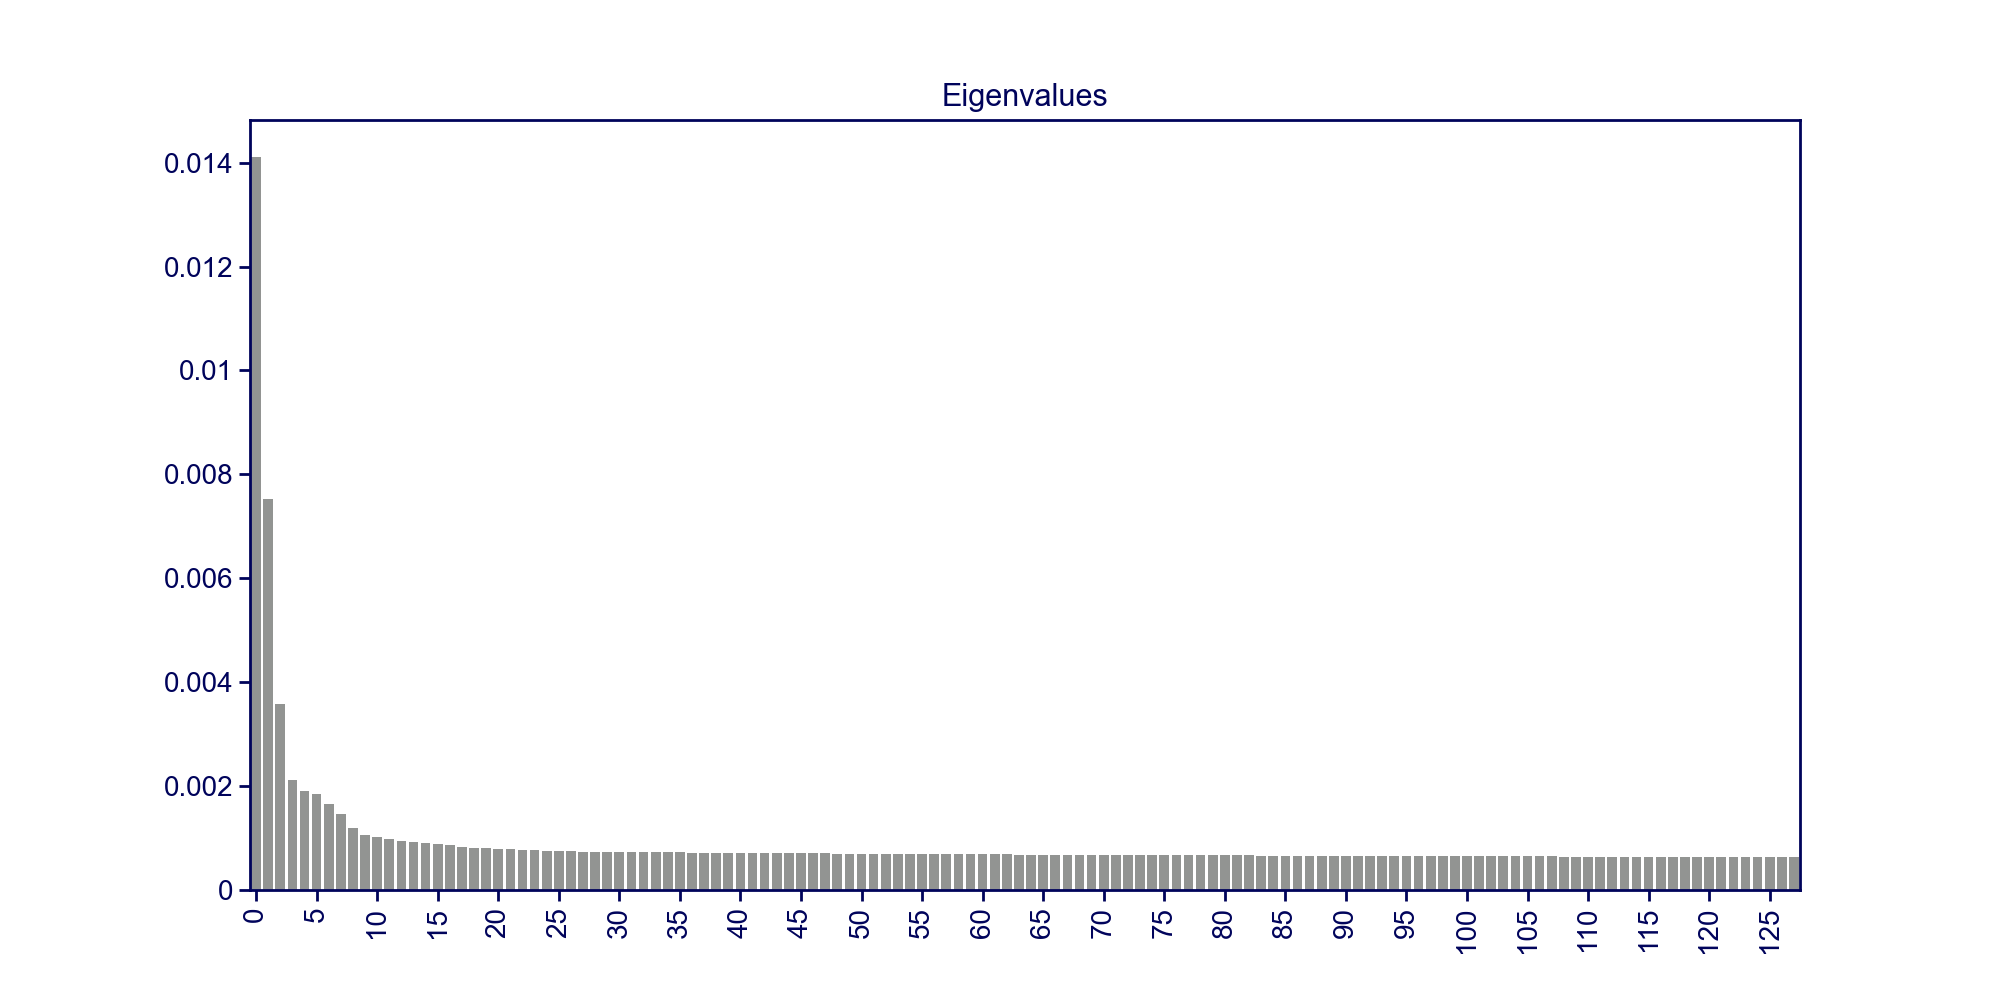

Percentage of variance explained:
[57.59342951 16.40457836  3.71242828  1.28702947  1.04829724  0.97856143
  0.78438095  0.62625069  0.40702336  0.31880943]
Weights of each dataset, assessing the contribution of each dataset to the compromise
[0.11175288 0.11159931 0.110424   0.11017844 0.10952869 0.11256764
 0.11157336 0.11176489 0.11061079]
Barplot of weights


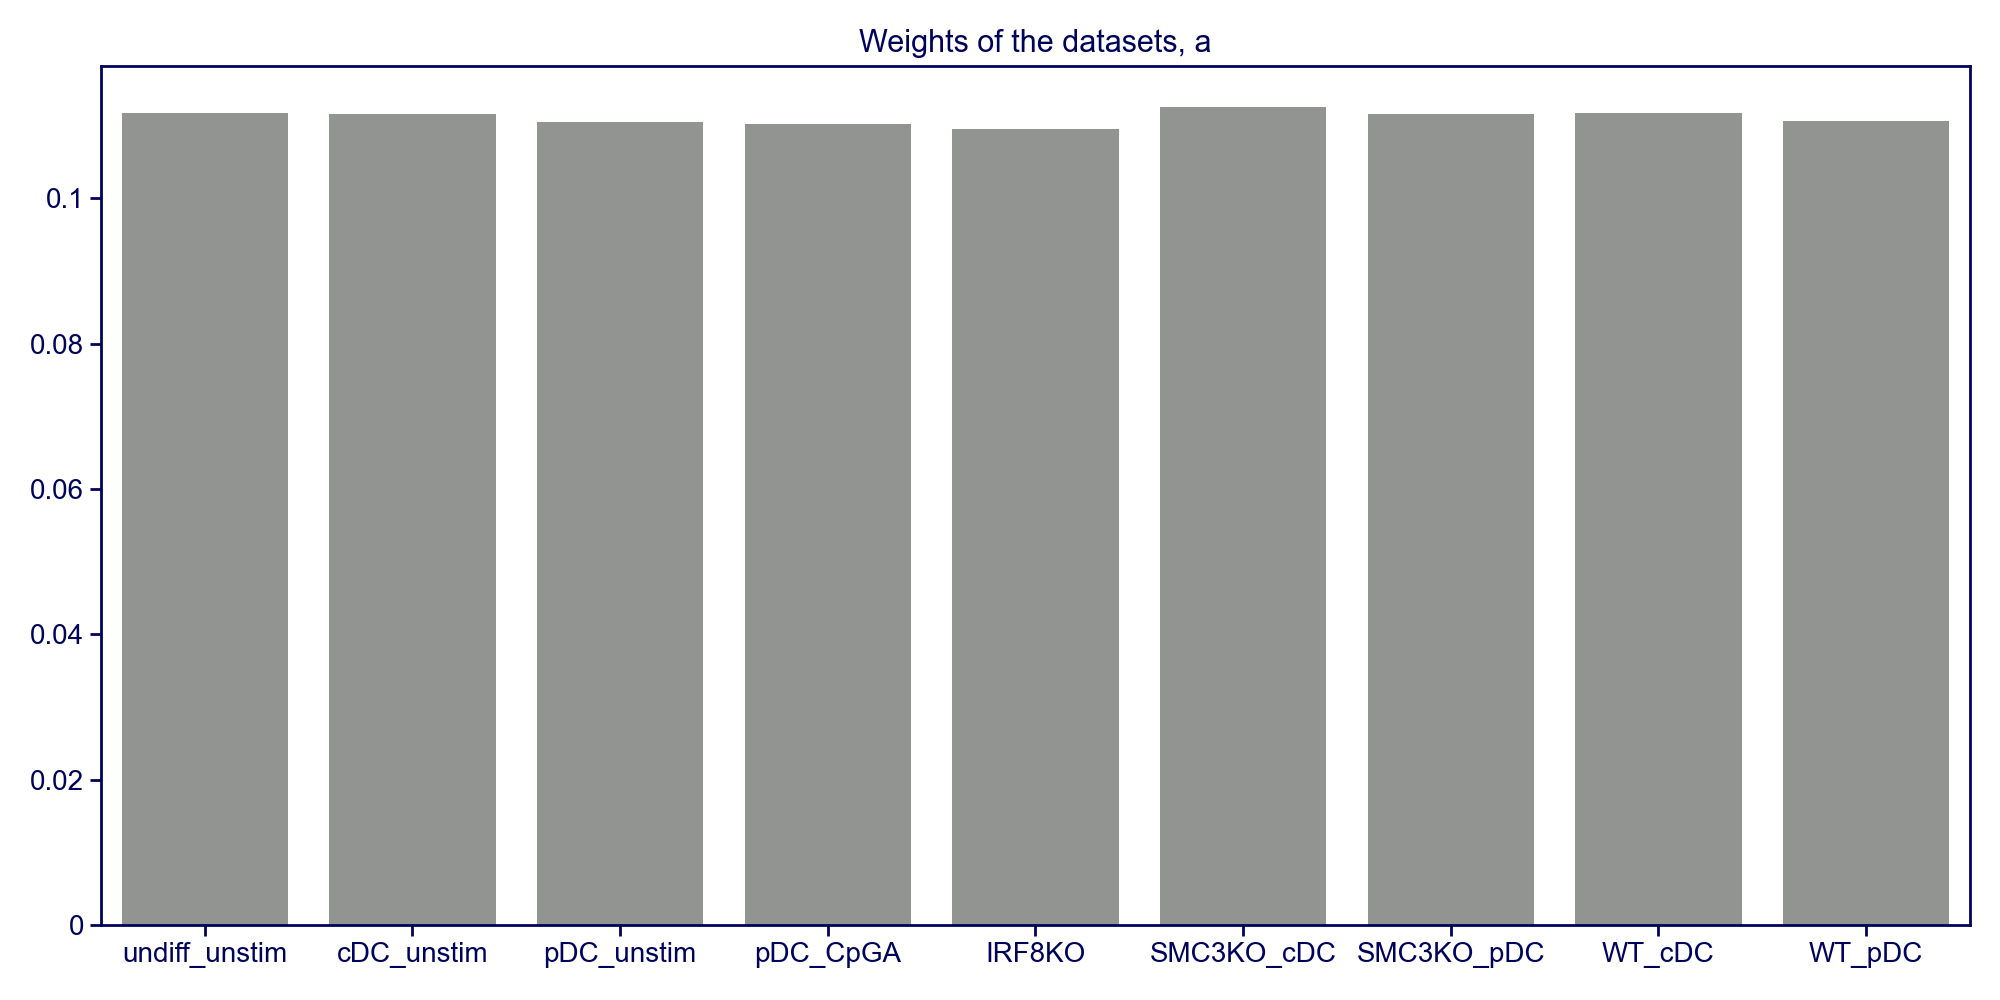

Heatmap of contributions of datasets to components


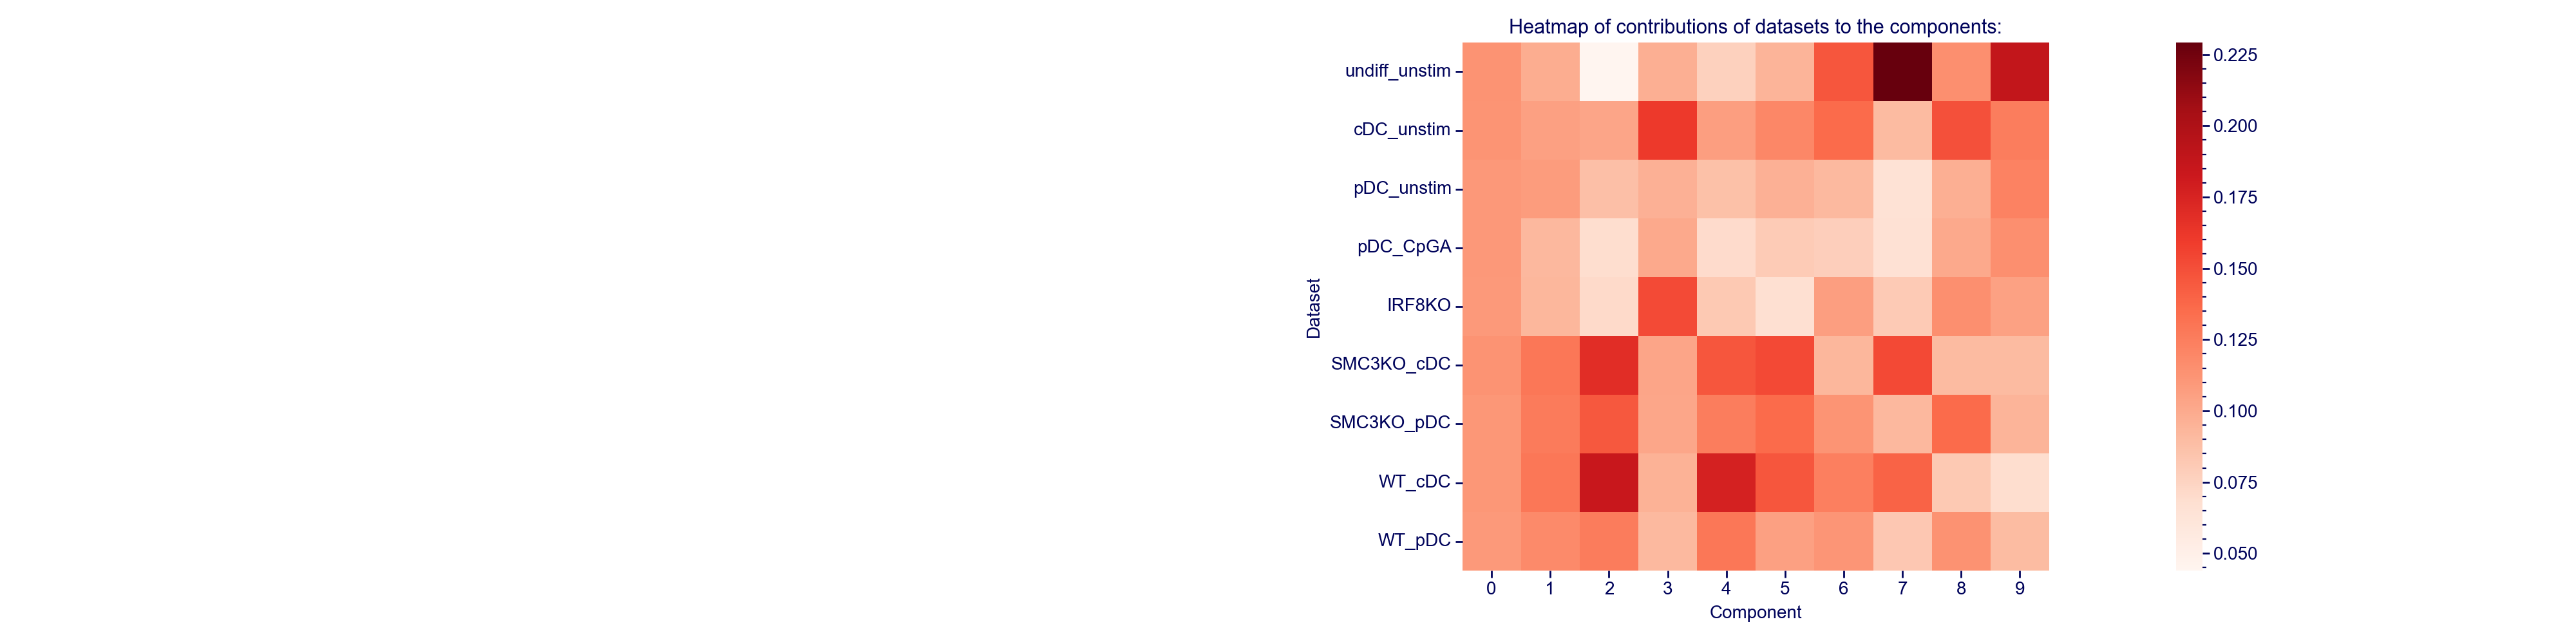

Contributions of genomic positions per component
Contribution of genomic positions per dataset into component 1
Quick scatterplots of loadings
Quick scatterplots of factor scores


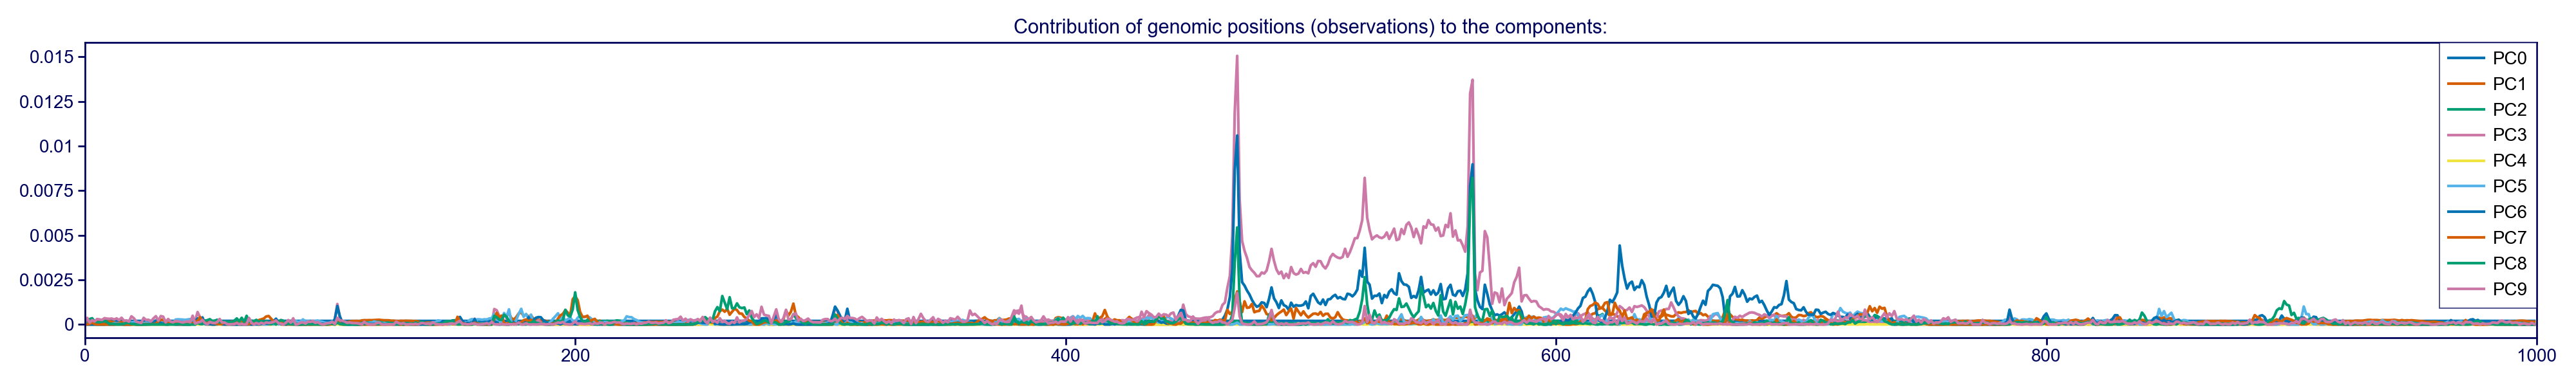

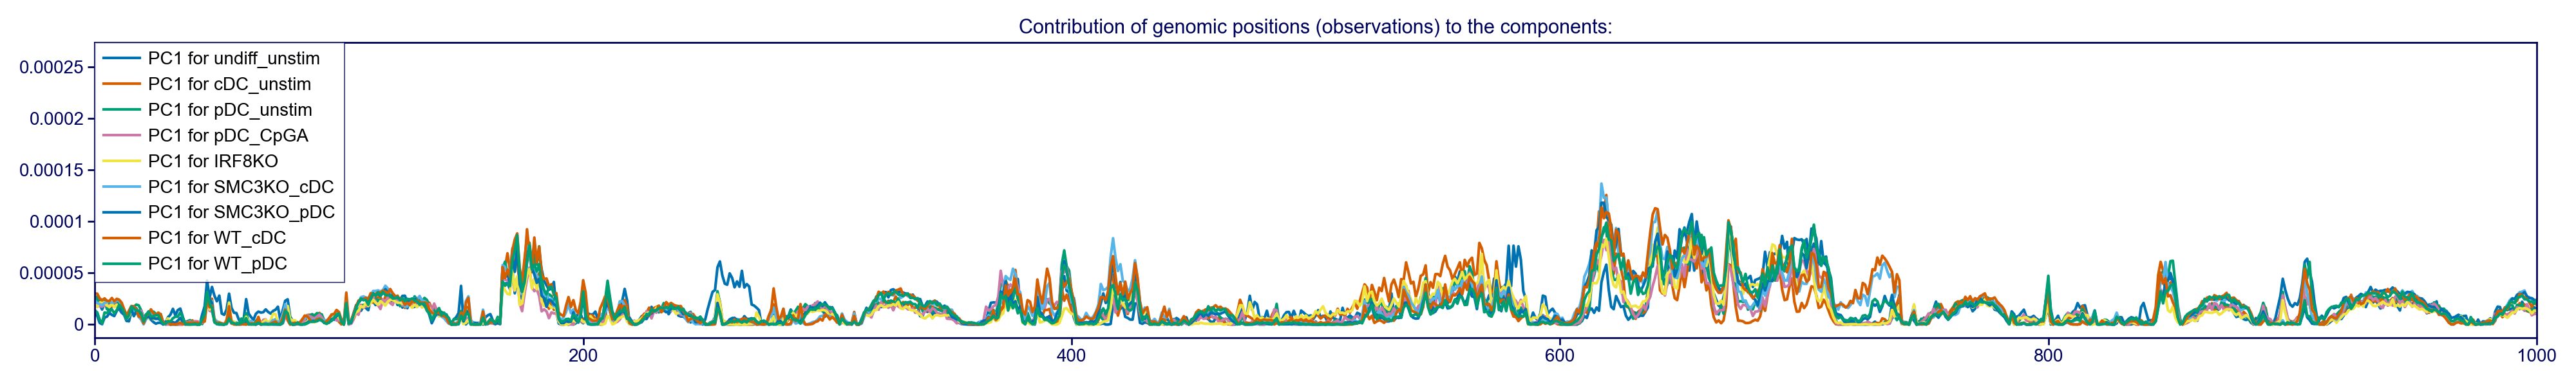

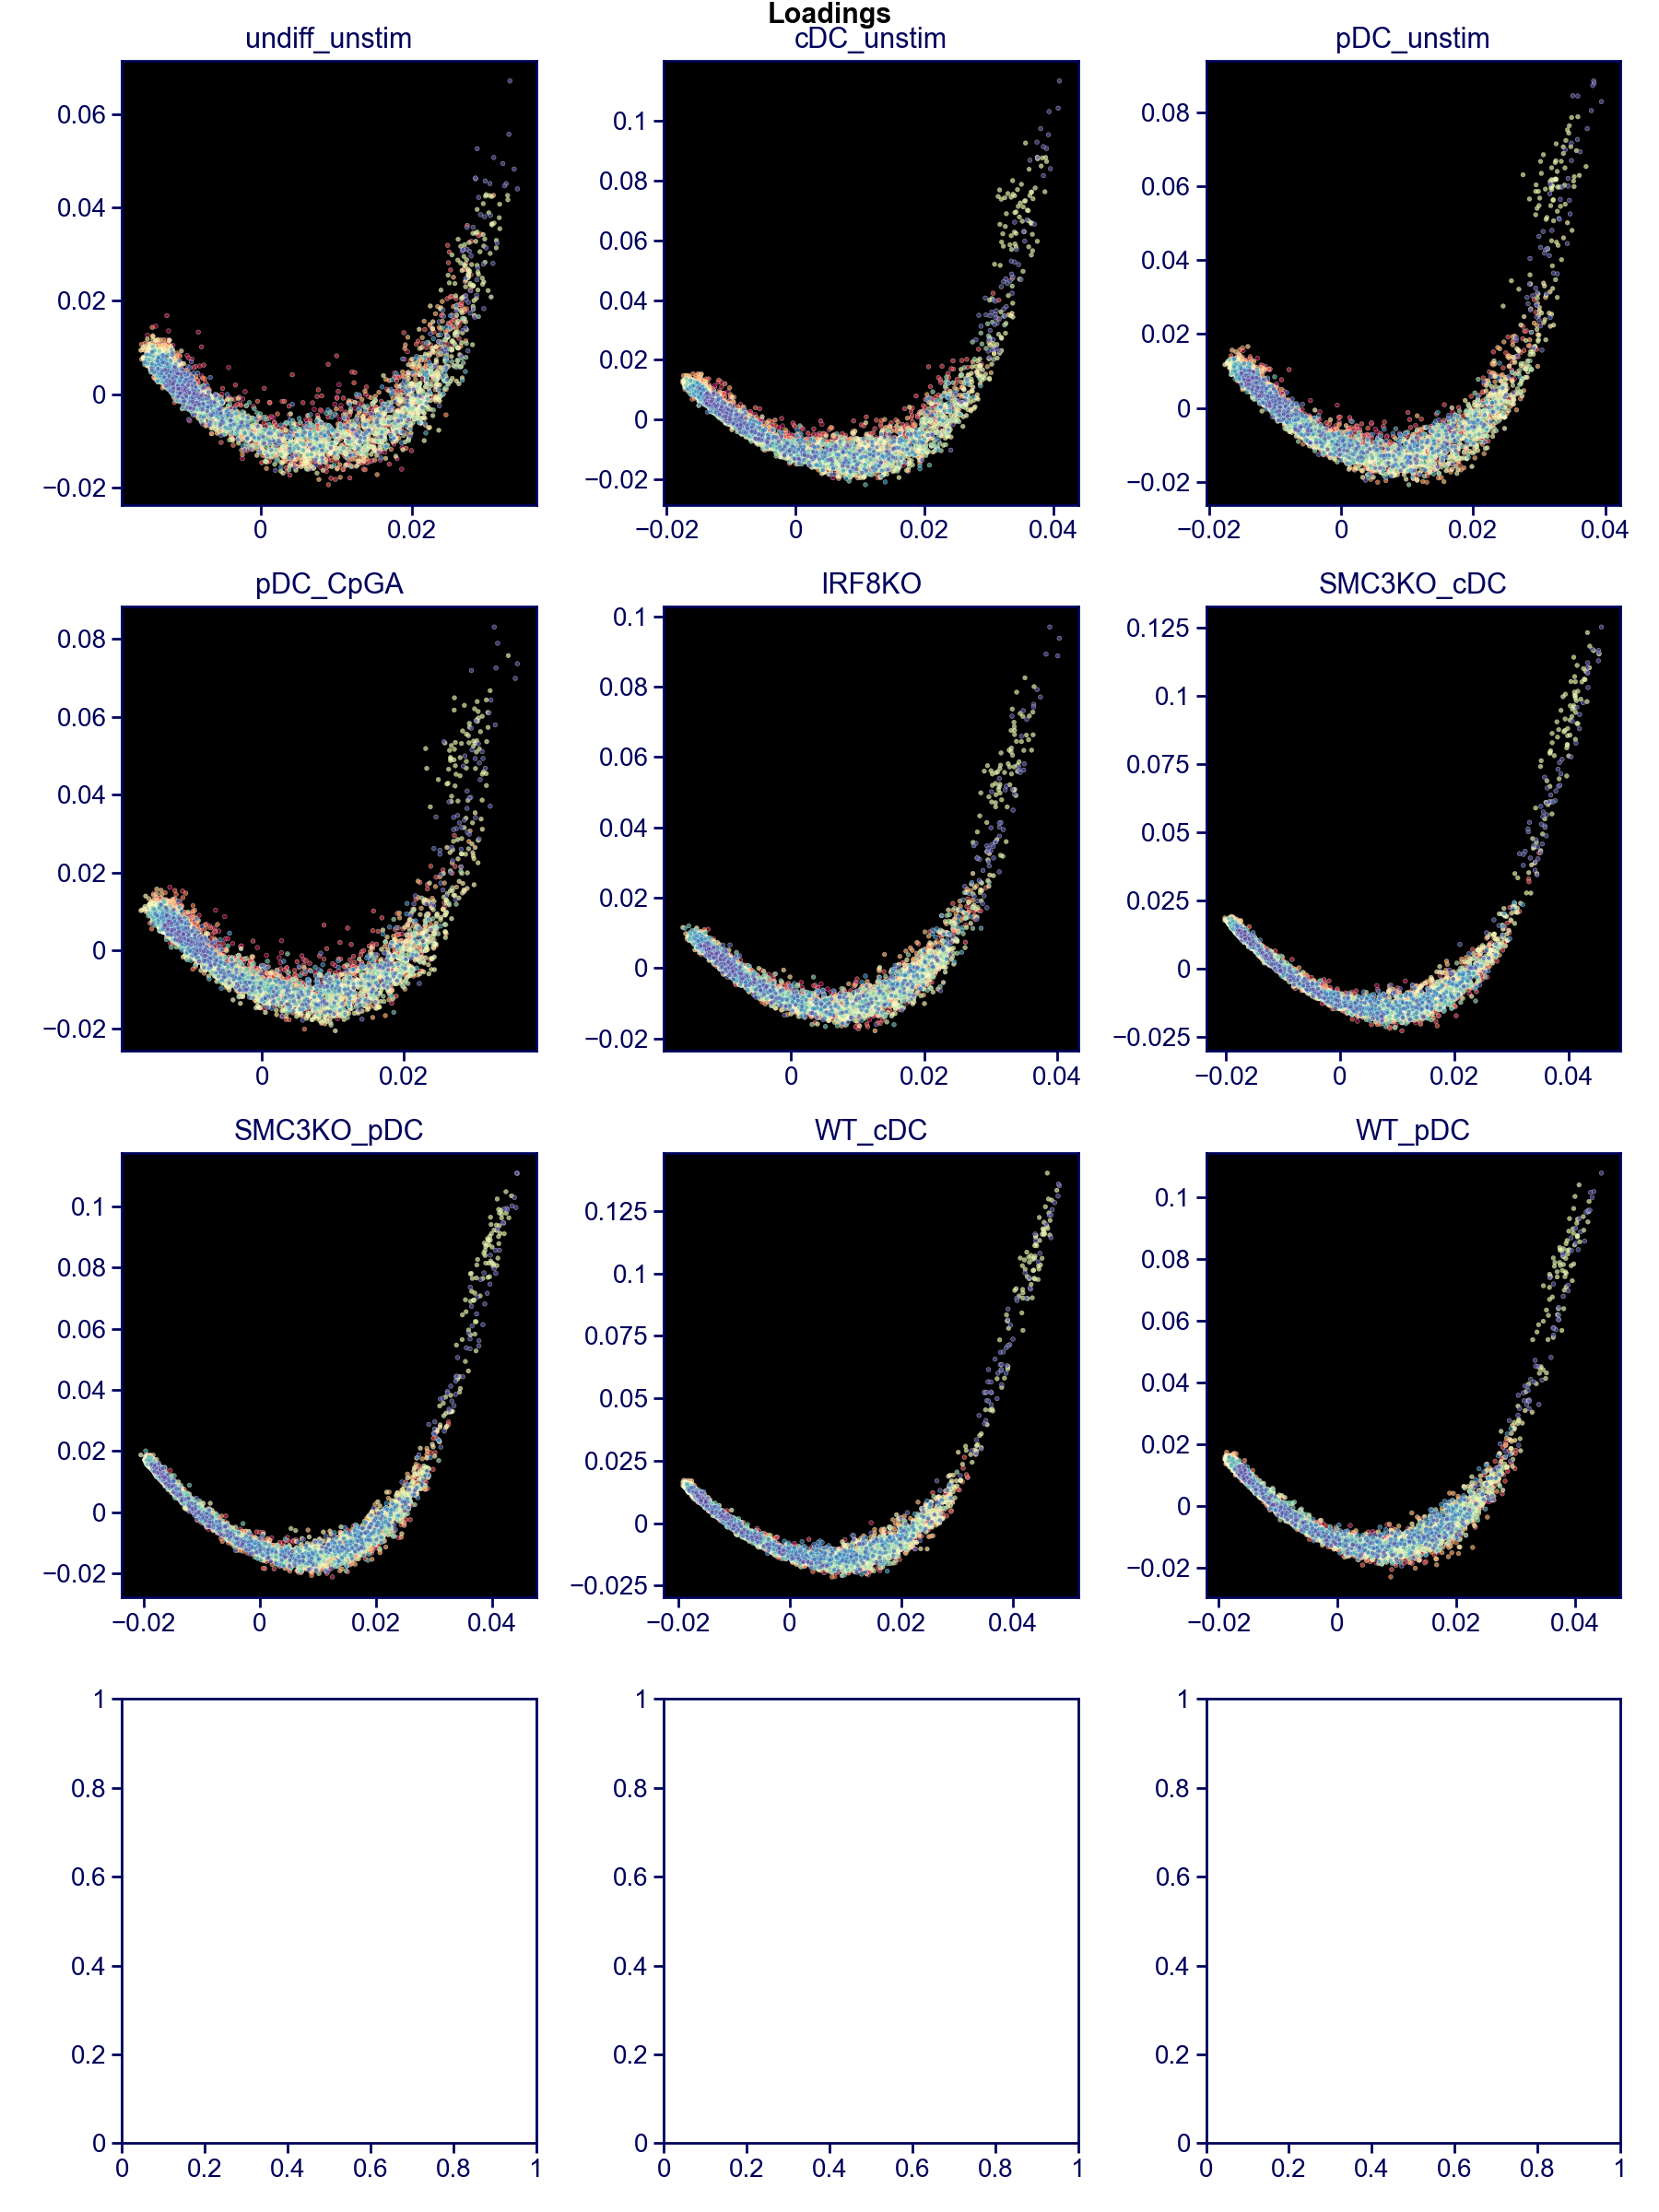

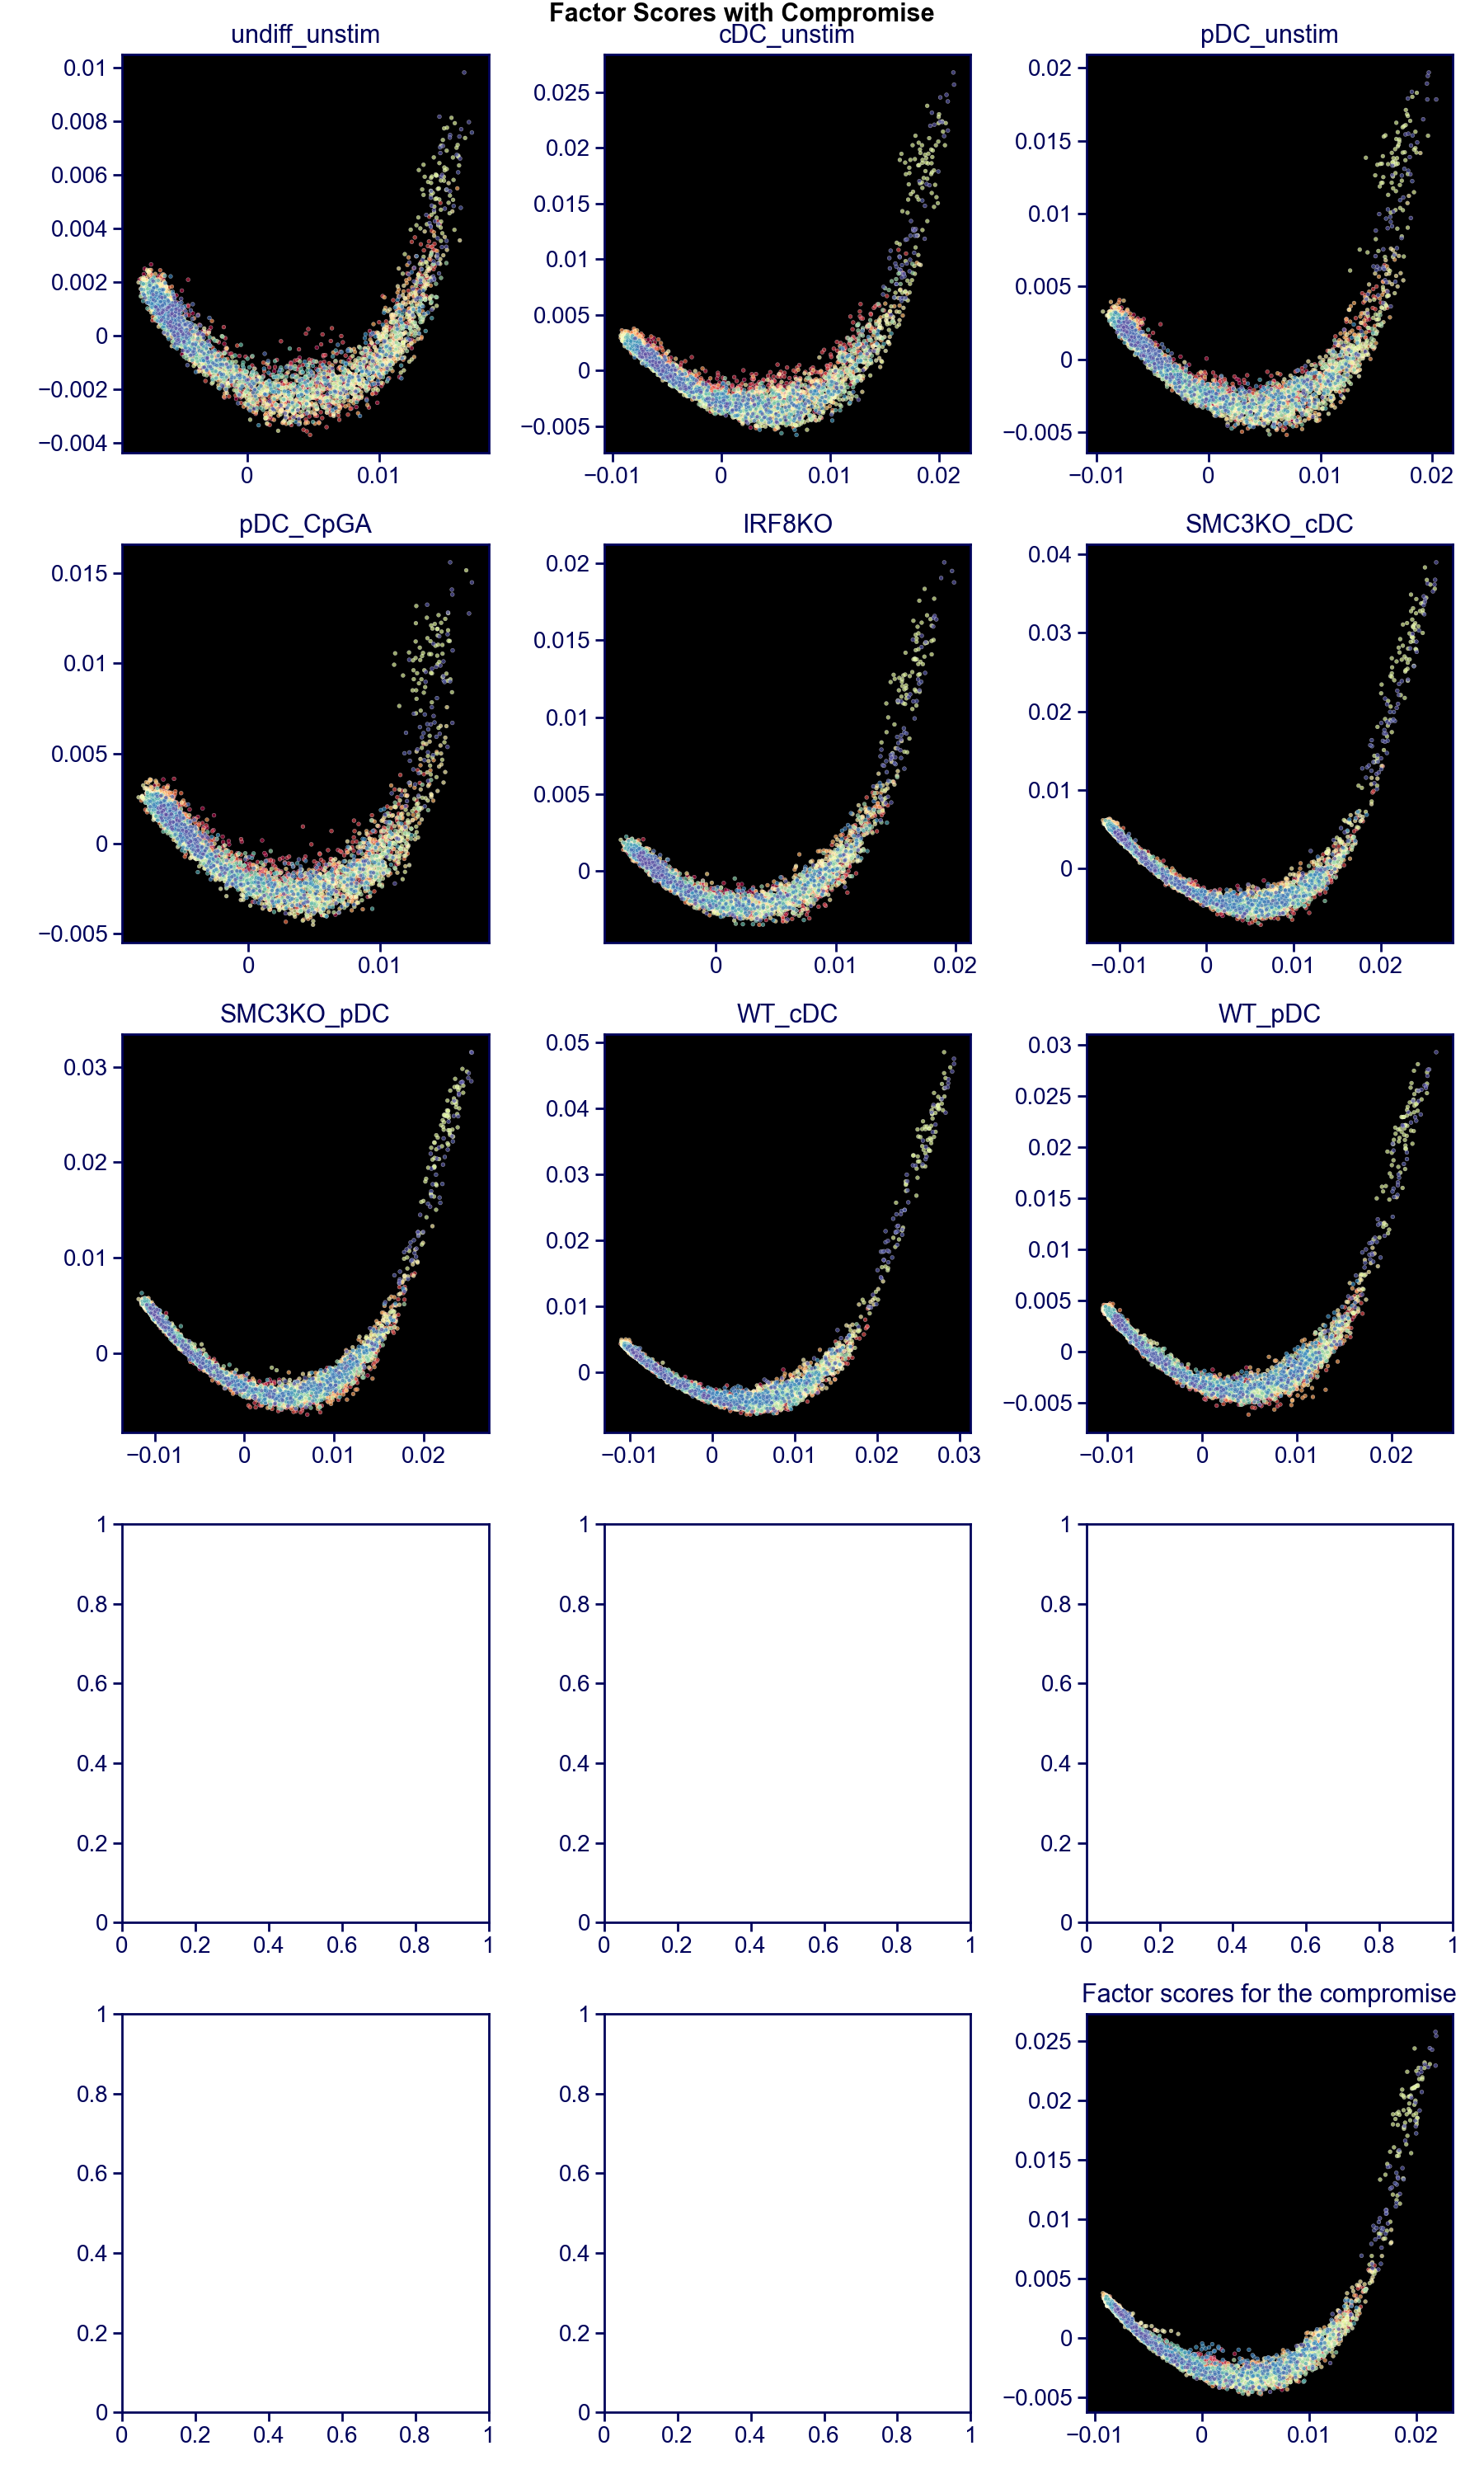

In [15]:
joint_lib.summary_statis(STATIS_model, CONDITIONS_CONSENSUS, n_comp_plot=10, COMP_TARGET=1, REGION=(0, 1000) )

In [16]:
# Variance explained with 1st value
( 100*np.power(STATIS_model.D_, 2) / sum(np.power(STATIS_model.D_, 2)) )[:10]

array([57.59342951, 16.40457836,  3.71242828,  1.28702947,  1.04829724,
        0.97856143,  0.78438095,  0.62625069,  0.40702336,  0.31880943])

In [17]:
# Variance explained without 1st value
( 100*np.power(STATIS_model.D_[1:], 2) / sum(np.power(STATIS_model.D_[1:], 2)) )[:10]

array([38.68404866,  8.75437045,  3.03497654,  2.47201608,  2.30757031,
        1.84966845,  1.4767775 ,  0.95981201,  0.75179254,  0.70937806])

In [18]:
# Variance explained without 1st value, cumulative
( np.cumsum( 100 * np.power(STATIS_model.D_[1:], 2) / sum(np.power(STATIS_model.D_[1:], 2)) ) )[:13]

array([38.68404866, 47.43841911, 50.47339566, 52.94541173, 55.25298205,
       57.10265049, 58.57942799, 59.53924   , 60.29103254, 61.0004106 ,
       61.65469363, 62.25895583, 62.84266483])

## GSVD properties

In [19]:
palette = sns.color_palette('538')

### Singular values spectrum

In [20]:
max(STATIS_model.D_)

0.014115762607947264

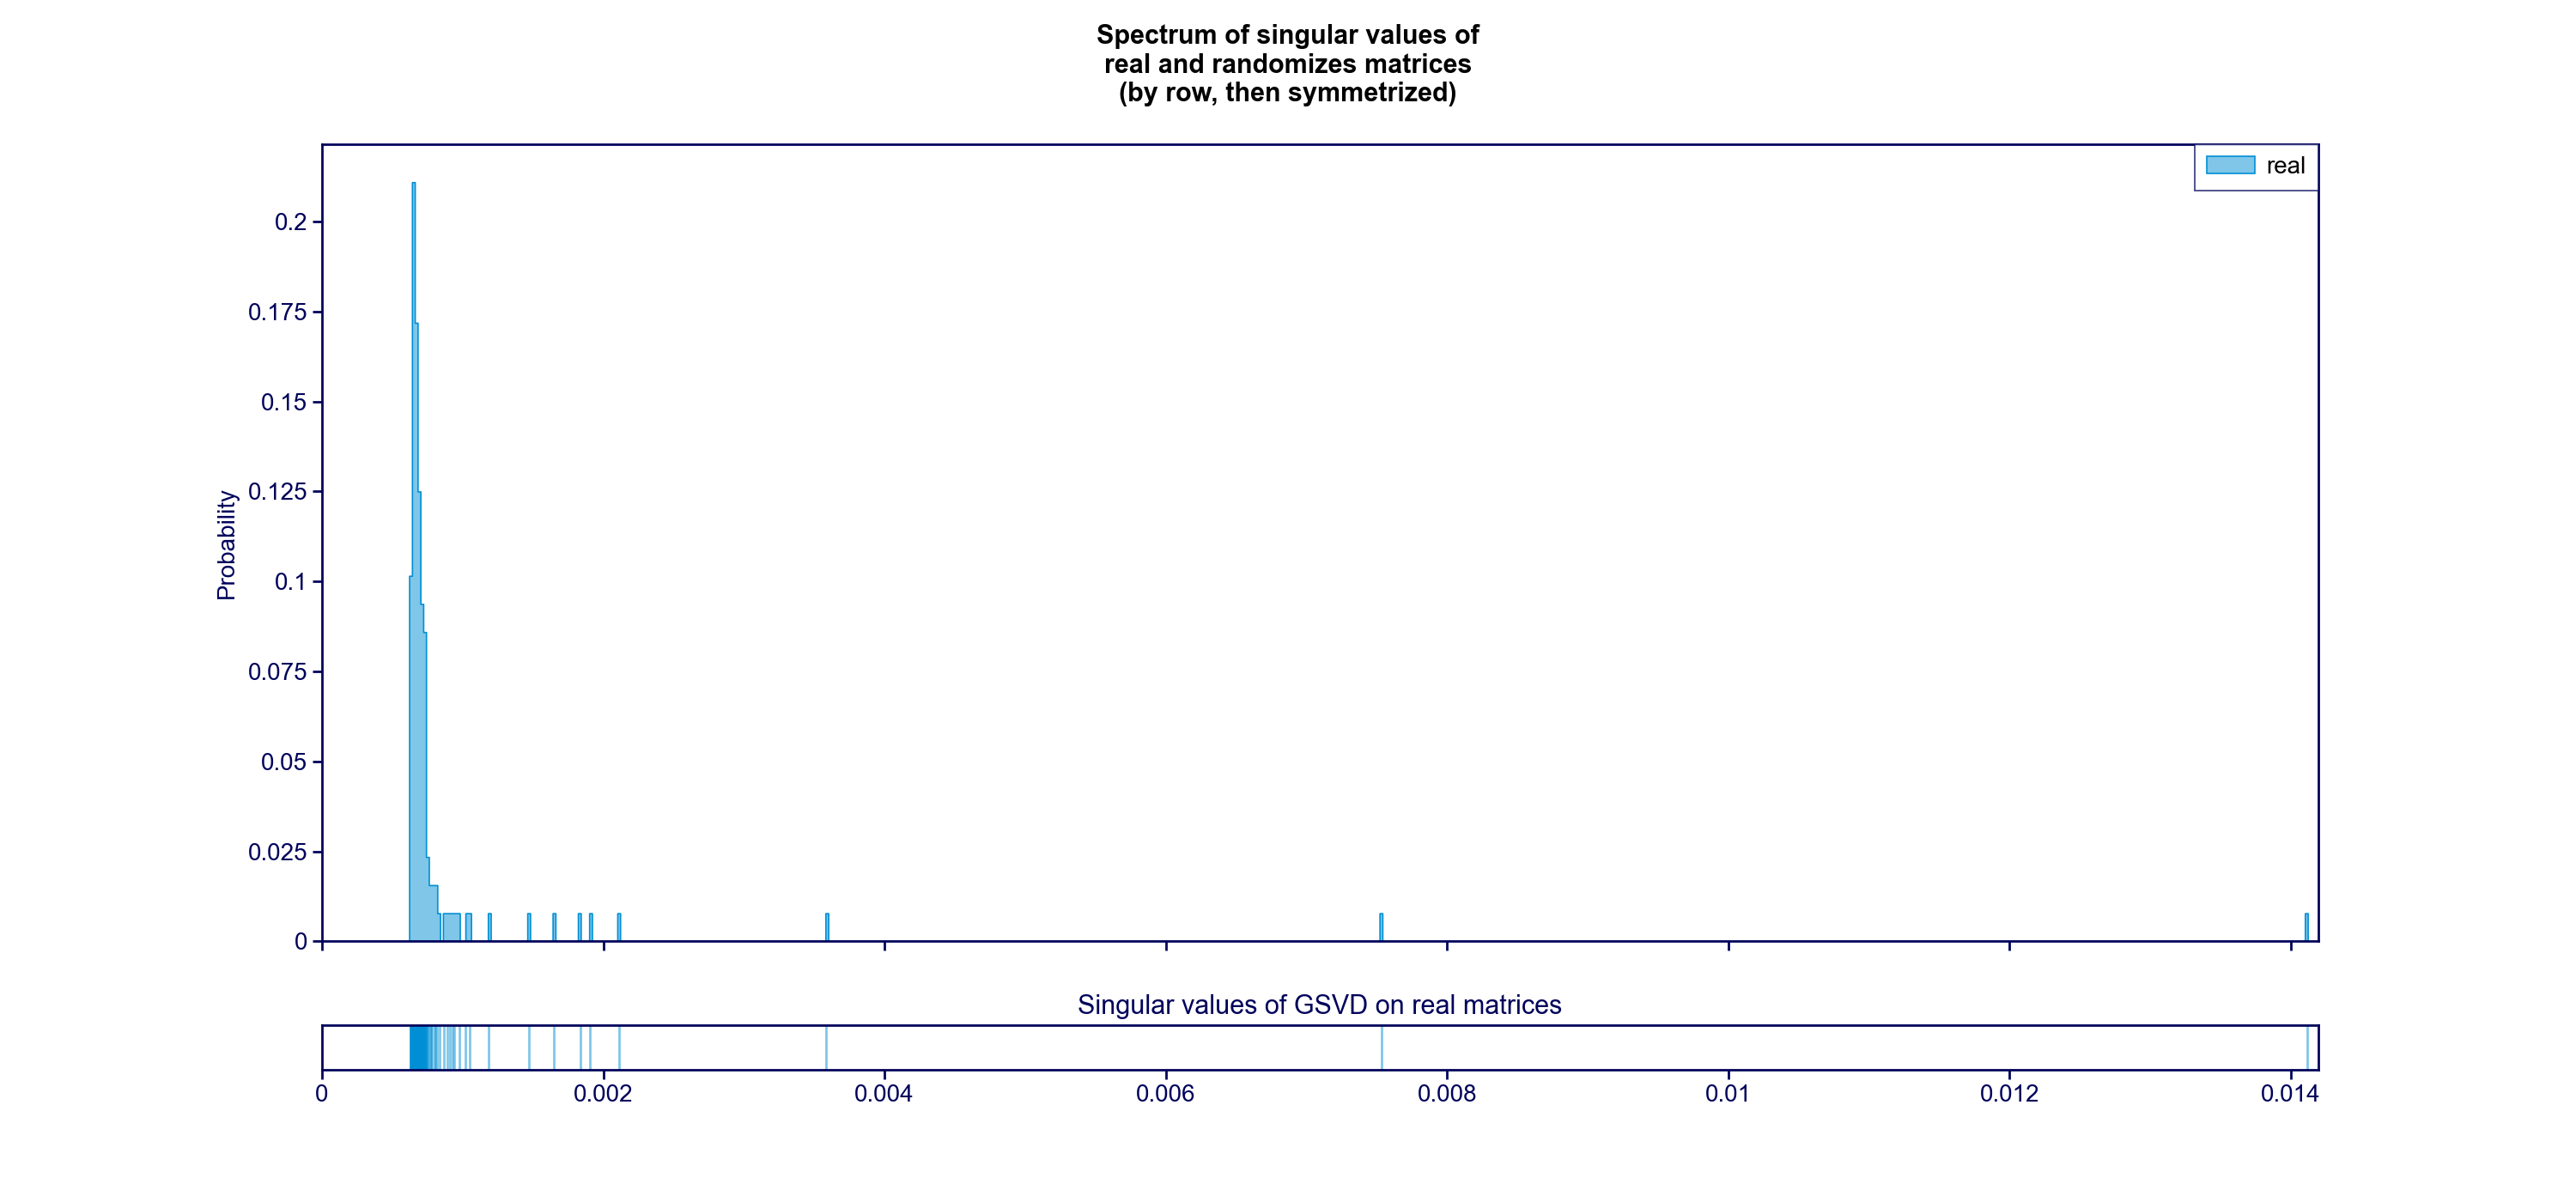

In [21]:
xmax = max(STATIS_model.D_)+8e-5

fig, axes = plt.subplots(2, 1, figsize=[15, 7], gridspec_kw={'height_ratios':[9, 0.5]}, sharex=True)

sns.histplot( STATIS_model.D_, bins=np.arange(0, xmax, 2e-5), 
             stat='probability', element='step', alpha=0.5, label="real",
             ax=axes[0], color=palette[0] )

sns.rugplot( x=STATIS_model.D_, ax=axes[1], height=1, alpha=0.5, color=palette[0] )

plt.xlim(0, xmax)

axes[0].legend()

axes[1].set_yticks([])

axes[1].set_title("Singular values of GSVD on real matrices")

fig.suptitle("Spectrum of singular values of\nreal and randomizes matrices\n(by row, then symmetrized)")

fig.savefig(f"{OUTPUT_FOLDER}/SV-spectrum.{CHROM}.{BINSIZE}.png")
fig.savefig(f"{OUTPUT_FOLDER}/SV-spectrum.{CHROM}.{BINSIZE}.pdf")

### Correlation of factor dimensions on real matrices between real and fake matrices, as well as with epigenetics

In [22]:
N_COMP = 10
bins_region, _ = joint_lib.parse_statis_output(STATIS_model, 
                                            bins_region, 
                                            CONDITIONS_CONSENSUS, 
                                            good_bins=GOOD_BINS, 
                                            n_comp=N_COMP+1,
                                            phasing_track=bins_region['GC'].values,
                                            phasing_method='spearman',
                                            postfix="")

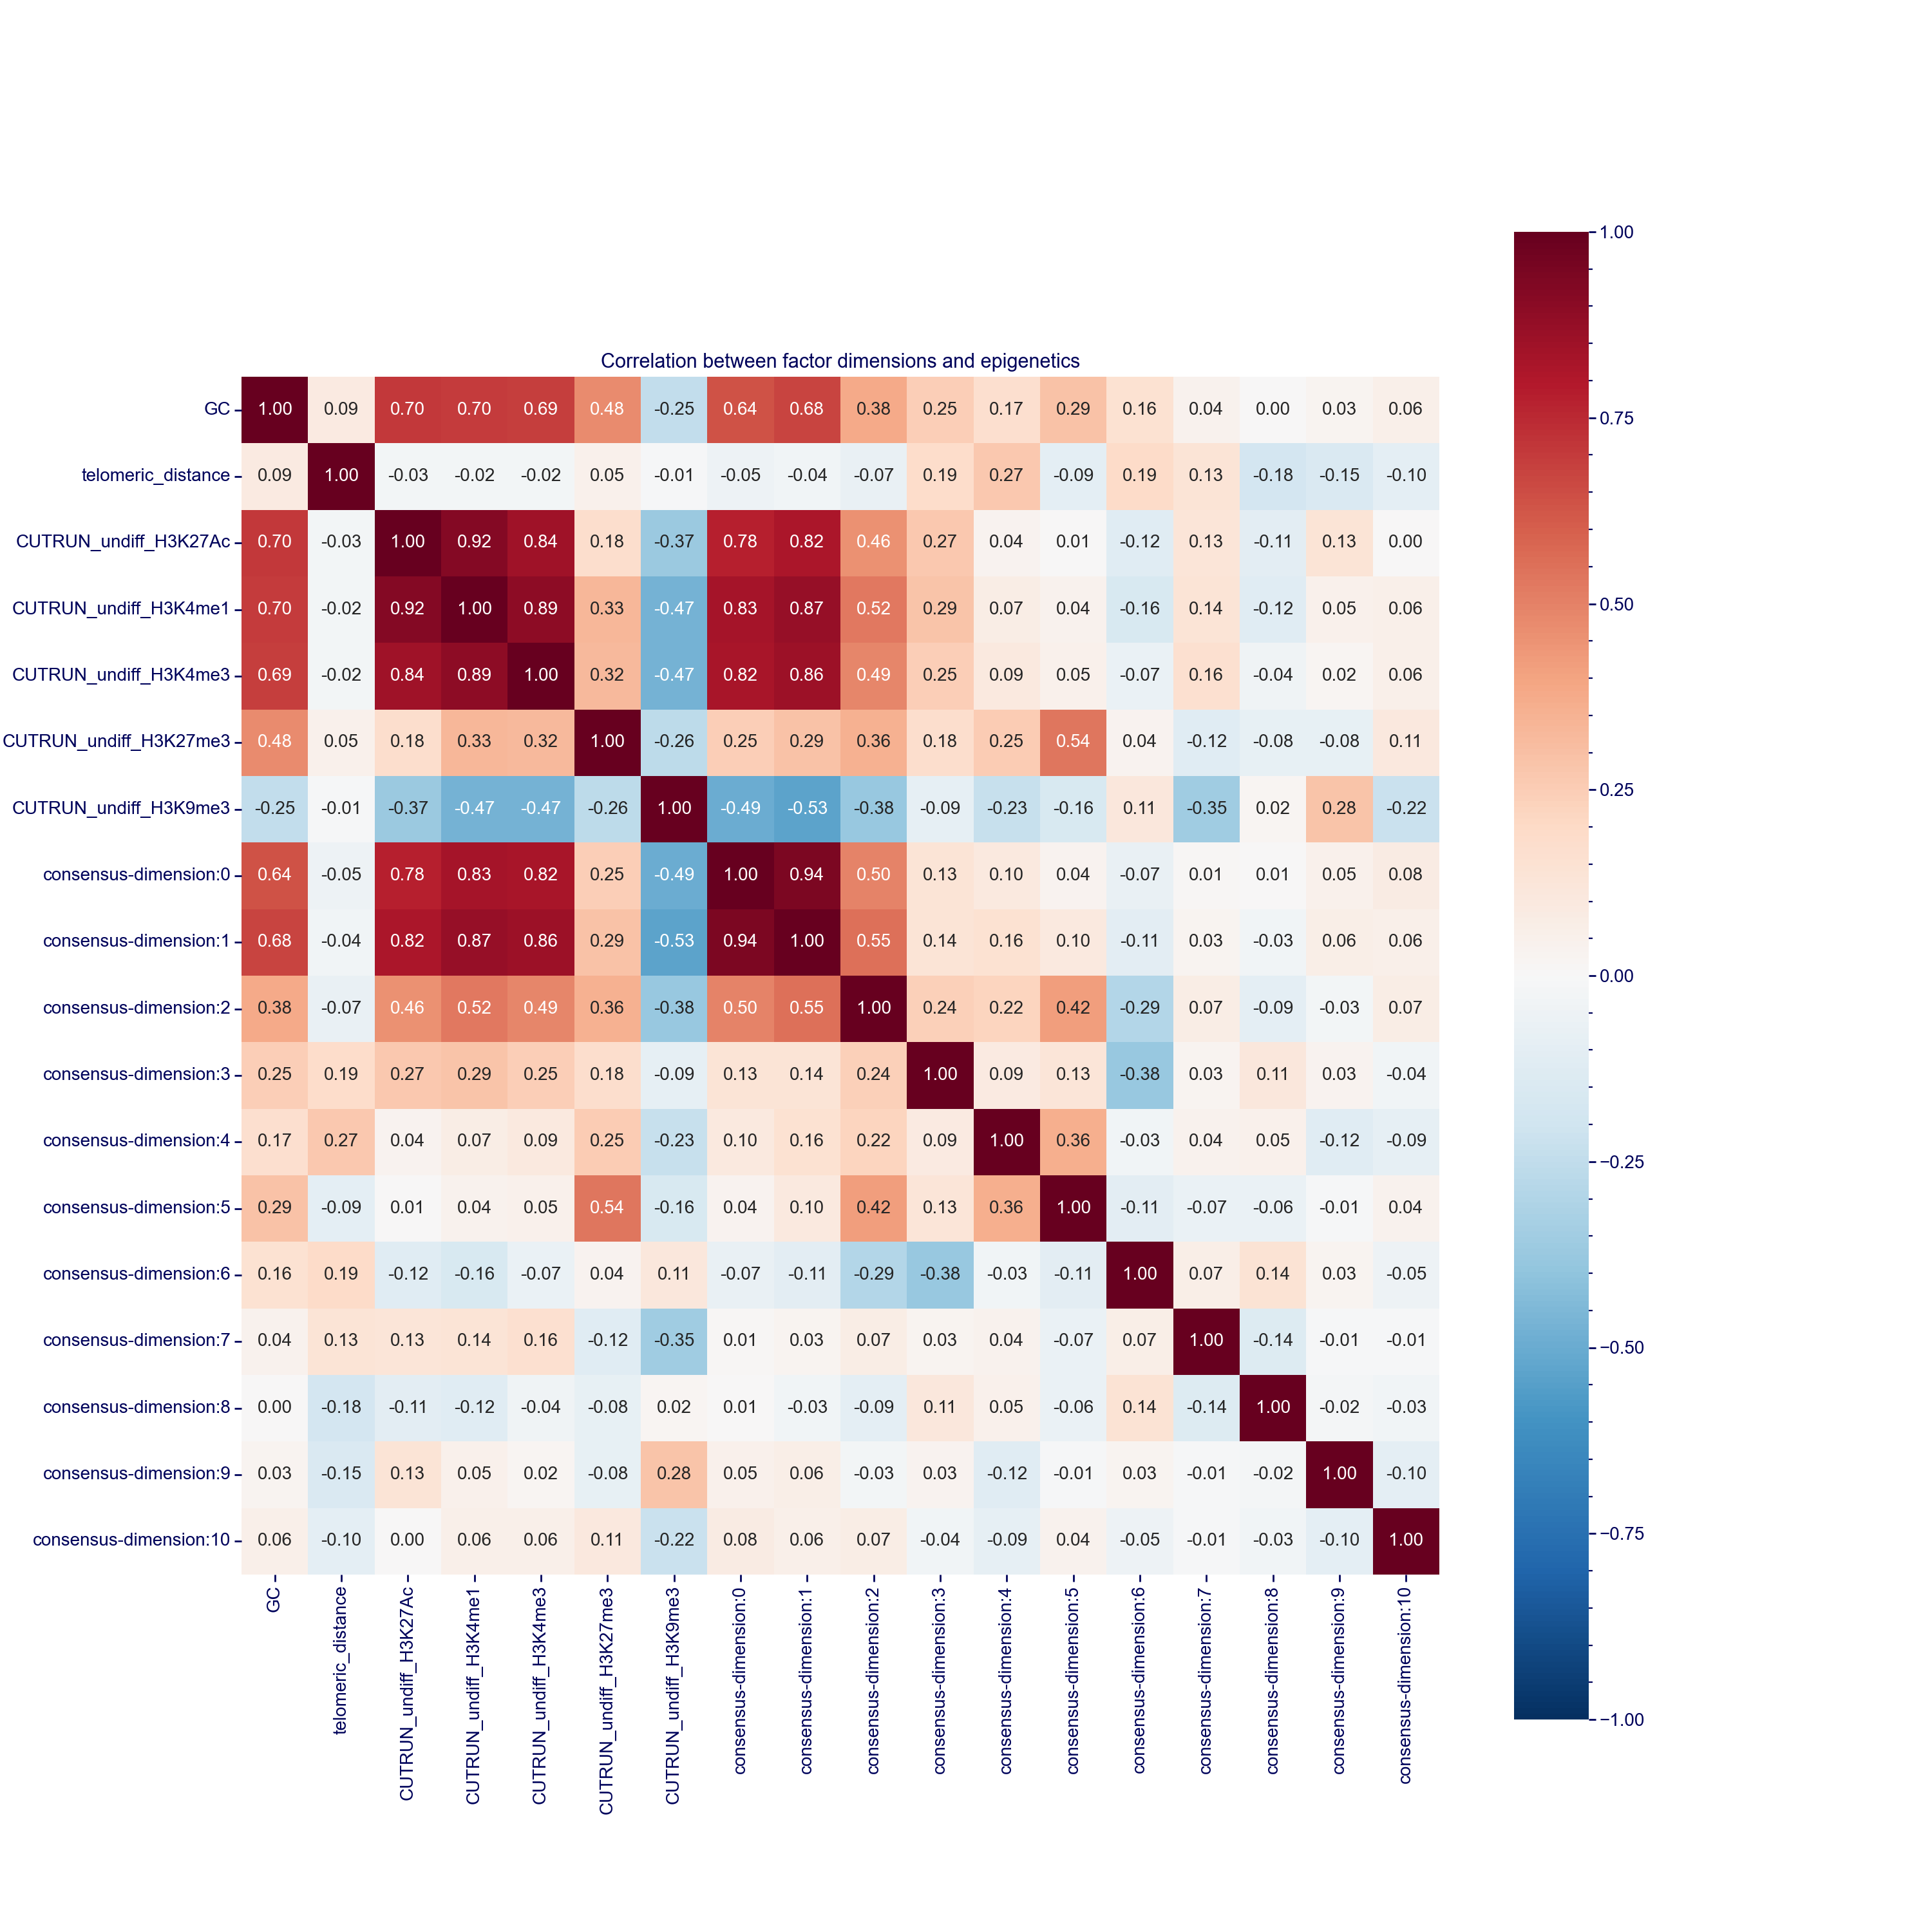

In [23]:
cols = ['GC', 'telomeric_distance']+['CUTRUN_undiff_H3K27Ac', 'CUTRUN_undiff_H3K4me1', 'CUTRUN_undiff_H3K4me3', 'CUTRUN_undiff_H3K27me3', 'CUTRUN_undiff_H3K9me3']+[x for x in bins_region.columns if 'consensus-dimension' in x]

corr_mtx = bins_region.loc[:, cols].dropna(axis=0).corr(method='spearman')

plt.figure(figsize=[15, 15])
sns.heatmap(corr_mtx, cmap='RdBu_r', vmin=-1, vmax=1, square=True, annot=True, fmt=".2f")
plt.title("Correlation between factor dimensions and epigenetics")

plt.savefig(f"{OUTPUT_FOLDER}/factor-correlations.{CHROM}.{BINSIZE}.png")
plt.savefig(f"{OUTPUT_FOLDER}/factor-correlations.{CHROM}.{BINSIZE}.pdf")

## Projection to the consensus from cis to trans

In [24]:
N_COMP = 25 #128
bins_region, variance_explained = joint_lib.parse_statis_output(STATIS_model, 
                                            bins_region, 
                                            CONDITIONS_CONSENSUS, 
                                            good_bins=GOOD_BINS, 
                                            n_comp=N_COMP,
                                            phasing_track=bins_region['GC'].values,
                                            phasing_method='spearman',
                                            postfix="")

In [25]:
cols_reference = [f'consensus-dimension:{i}' for i in range(N_COMP)]
reference = bins_region.loc[:, cols_reference].values

In [26]:
np.sum( bins_region.loc[:, 'is_bin_valid'] )

4930

In [27]:
# Project all the matrices to the consensus and store the output:
for cond in (pbar:= tqdm.tqdm(CONDITIONS)):
    pbar.set_postfix_str(cond)
    
    proj = joint_lib.transform(MTX_DICT[cond][region], reference, whiten=False, variance_explained=None)

    cols = [f'transformed:{cond}:{i}' for i in range(N_COMP)]
    bins_region.loc[:, cols] = proj

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.79it/s, WT_pDC_R2]


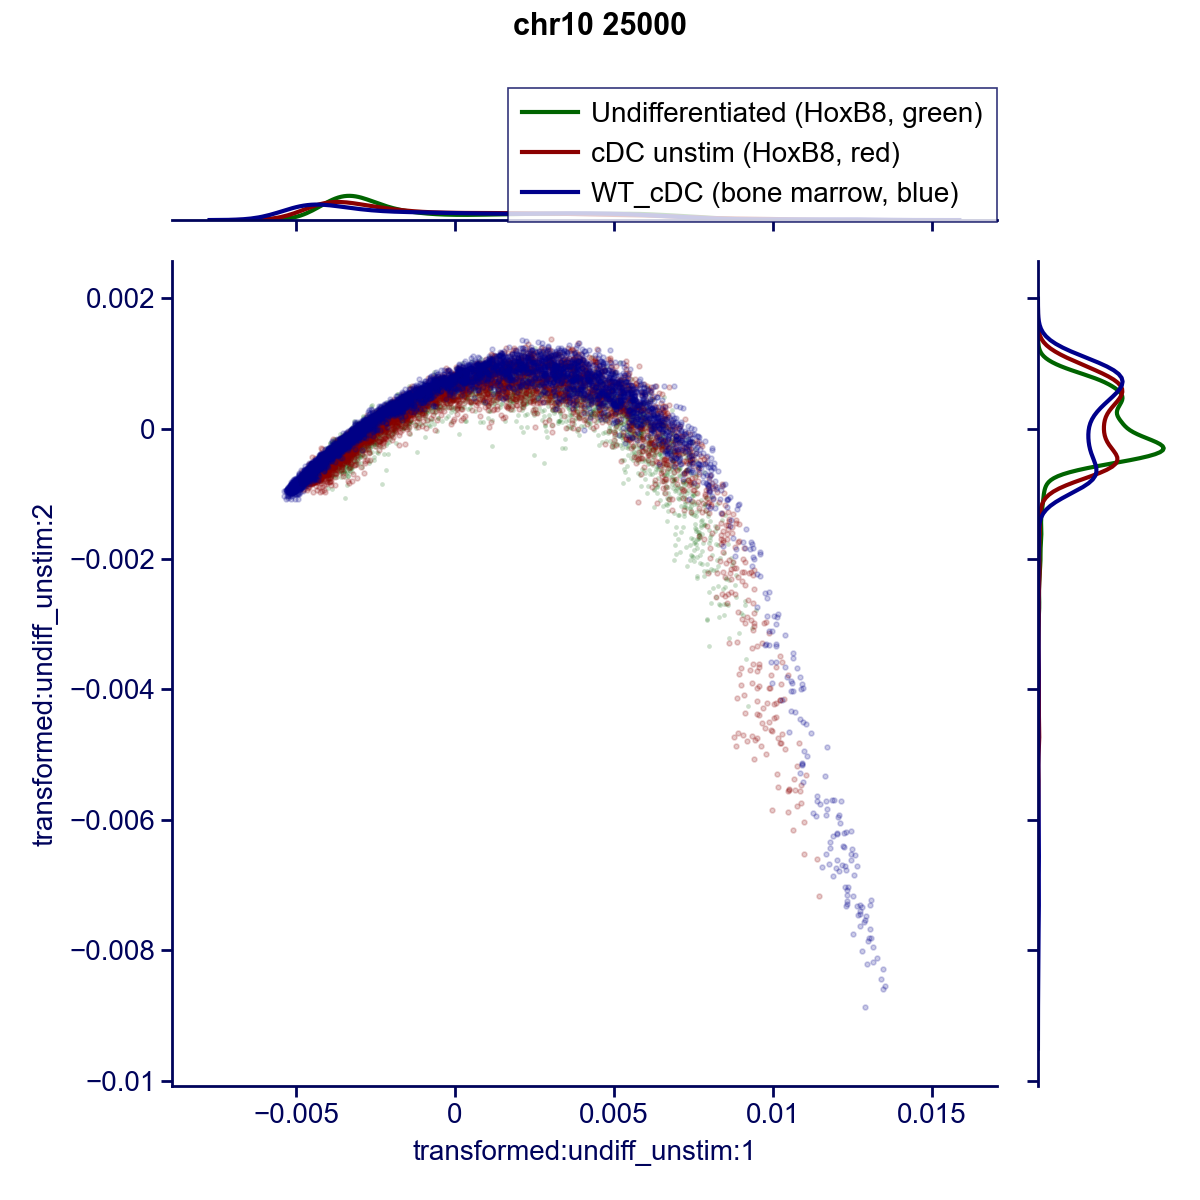

In [28]:
list_toplot = [
    ["undiff_unstim", "Undifferentiated (HoxB8, green)", 'darkgreen'],
    ["cDC_unstim", "cDC unstim (HoxB8, red)", 'darkred'],
    ["WT_cDC", "WT_cDC (bone marrow, blue)", 'darkblue'],
]
i1 = 1
i2 = 2
mode = "transformed"

axs = None
for cond, label, color in list_toplot:
    x = f'{mode}:{cond}:{i1}'
    y = f'{mode}:{cond}:{i2}'
    if axs is None:
        axs = sns.jointplot(
            x=x,
            y=y,
            data=bins_region,
            color=color,
            s=3,
            alpha=0.2,
            label=label,
            legend=False,
            marginal_kws={'alpha':0, 'edgecolor':'white'}
        )
    else:
        axs.ax_joint.scatter(x=x,
        y=y,
        data=bins_region,
        color=color,
        s=3,
        alpha=0.2,
        label=label,
    )       

    sns.kdeplot(bins_region[x], ax=axs.ax_marg_x, color=color, label=label)
    sns.kdeplot(bins_region[y], ax=axs.ax_marg_y, color=color, vertical=True)

# axs.ax_joint.legend()
axs.ax_marg_x.legend()

axs.fig.suptitle(f"{CHROM} {BINSIZE}", y=0.99)

plt.tight_layout()

plt.savefig(f"{OUTPUT_FOLDER}/scatterplot.comp1-comp2.undif-cDC.{CHROM}.{BINSIZE}.png")
plt.savefig(f"{OUTPUT_FOLDER}/scatterplot.comp1-comp2.undif-cDC.{CHROM}.{BINSIZE}.pdf")

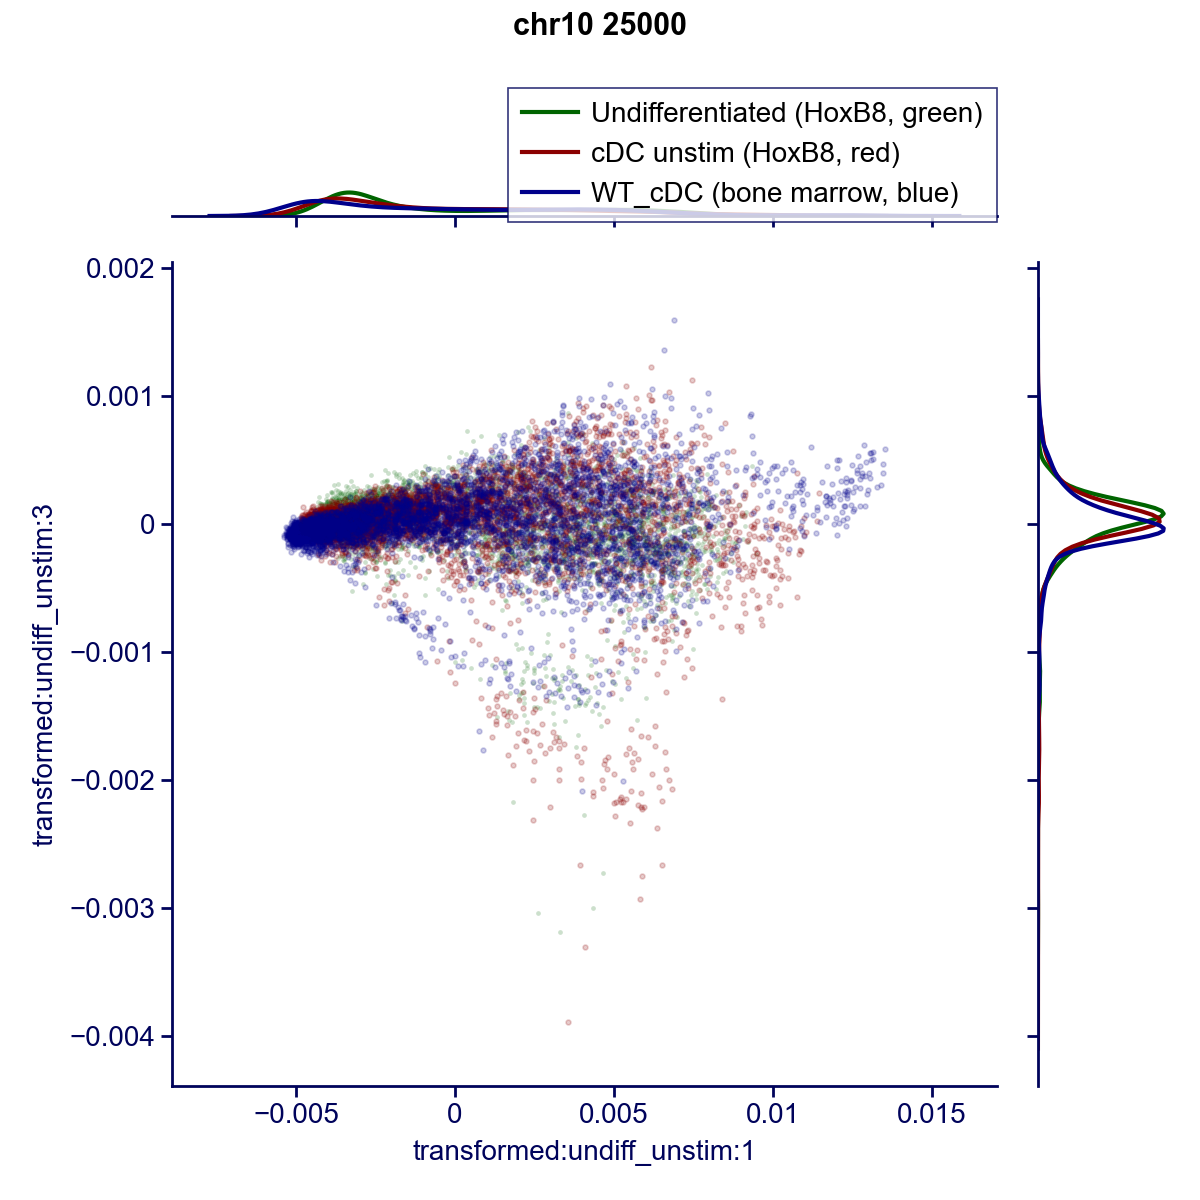

In [29]:
list_toplot = [
    ["undiff_unstim", "Undifferentiated (HoxB8, green)", 'darkgreen'],
    ["cDC_unstim", "cDC unstim (HoxB8, red)", 'darkred'],
    ["WT_cDC", "WT_cDC (bone marrow, blue)", 'darkblue'],
]
i1 = 1
i2 = 3
mode = "transformed"

axs = None
for cond, label, color in list_toplot:
    x = f'{mode}:{cond}:{i1}'
    y = f'{mode}:{cond}:{i2}'
    if axs is None:
        axs = sns.jointplot(
            x=x,
            y=y,
            data=bins_region,
            color=color,
            s=3,
            alpha=0.2,
            label=label,
            legend=False,
            marginal_kws={'alpha':0, 'edgecolor':'white'}
        )
    else:
        axs.ax_joint.scatter(x=x,
        y=y,
        data=bins_region,
        color=color,
        s=3,
        alpha=0.2,
        label=label,
    )       

    sns.kdeplot(bins_region[x], ax=axs.ax_marg_x, color=color, label=label)
    sns.kdeplot(bins_region[y], ax=axs.ax_marg_y, color=color, vertical=True)

# axs.ax_joint.legend()
axs.ax_marg_x.legend()



axs.fig.suptitle(f"{CHROM} {BINSIZE}", y=0.99)

plt.tight_layout()

plt.savefig(f"{OUTPUT_FOLDER}/scatterplot.comp1-comp3.undif-cDC.{CHROM}.{BINSIZE}.png")
plt.savefig(f"{OUTPUT_FOLDER}/scatterplot.comp1-comp3.undif-cDC.{CHROM}.{BINSIZE}.pdf")

### Clustering

#### Parameter sweep of GMM

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [31]:
conditions = CONDITIONS #list(ANNOTATIONS.sort_values(['model', 'stage', 'genotype', 'treatment']).cond.values)
mode = "transformed"
exclude_components = [0] # 0 is mean

n_bins = len(bins_region)
n_datasets = len(conditions)

In [32]:
stats = []

ns_clusters = np.arange(2, 21, 1)
ns_components = np.arange(1, 15, 1)

for n_clusters in tqdm.tqdm( ns_clusters ):
    for n_comp in ns_components:
        output_name = f"cluster-{n_comp}-{n_clusters}-{mode}"
        n_comp_full = n_comp + len(exclude_components)
        
        arr_toclust = np.concatenate(
            [bins_region.loc[:, [f"{mode}:{cond}:{n}" for n in range(0, n_comp_full) if n not in exclude_components]] for cond in CONDITIONS], 
            axis=0)
        is_good = np.all(np.isfinite(arr_toclust), axis=1)
        arr_toclust_collapsed = arr_toclust[is_good]

        arr_toeval_collapsed = arr_toclust_collapsed
        
        model = KMeans(
            n_clusters=n_clusters, 
            random_state=0,
            init='k-means++', 
            n_init=100, 
            max_iter=1000,
            tol=0.00001,
        )
        
        labels = np.full(shape=n_bins*n_datasets, fill_value=n_clusters)

        model.fit(arr_toclust_collapsed)
        labels[is_good] = model.predict(arr_toeval_collapsed)

        labels = labels.reshape([n_bins, n_datasets], order='F')

        # Write the output: 
        output_cols = [f"{output_name}:{cond}" for cond in conditions]
        bins_region.loc[:, output_cols] = labels
        bins_region.loc[:, output_cols] = bins_region.loc[:, output_cols].astype('category')
        
        score = silhouette_score(arr_toclust_collapsed, model.fit_predict(arr_toclust_collapsed))
        # bic = model.bic(arr_toclust_collapsed)
        # aic = model.aic(arr_toclust_collapsed)
        
        stats.append([n_clusters, n_comp, score])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [26:05:55<00:00, 4945.02s/it]


In [33]:
df_stats = pd.DataFrame( stats, columns=['n_clust', 'n_comp', 'silhouette'] )

[autoreload of _distutils_hack failed: Traceback (most recent call last):
  File "/home/agalicina/anaconda3/envs/spec/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/agalicina/anaconda3/envs/spec/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/home/agalicina/anaconda3/envs/spec/lib/python3.9/importlib/__init__.py", line 166, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
  File "<frozen importlib._bootstrap>", line 925, in _find_spec
  File "/home/agalicina/anaconda3/envs/spec/lib/python3.9/site-packages/_distutils_hack/__init__.py", line 95, in find_spec
NameError: name 'locals' is not defined
]
[autoreload of pkg_resources.extern.packaging.specifiers failed: Traceback (most recent call last):
  File "/home/agalicina/anaconda3/envs/spec/lib/python3.9/site-packages/IPython/extension

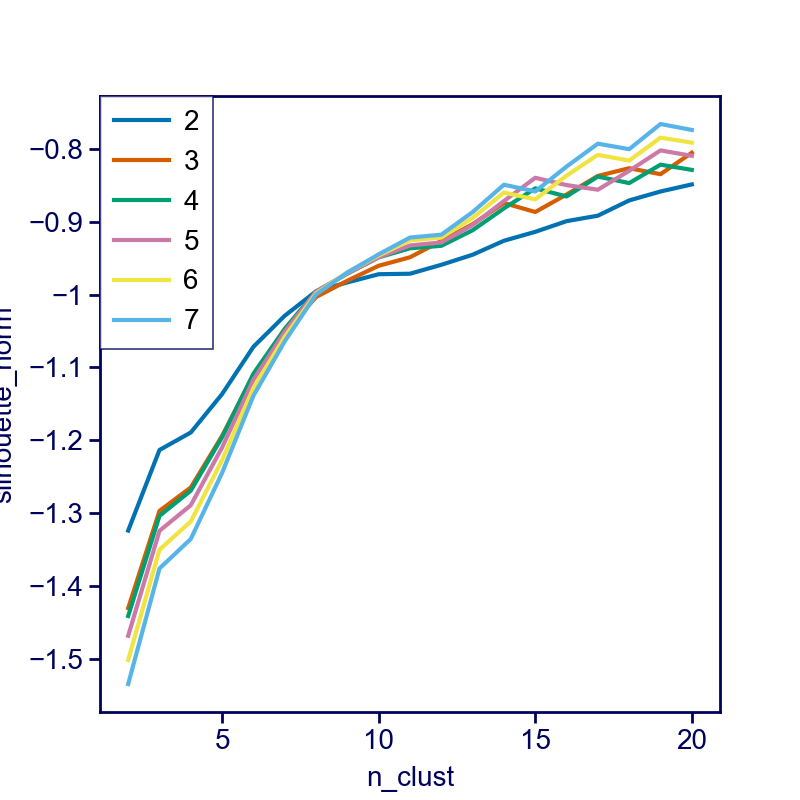

In [34]:
for n_comp in np.arange(2, 8, 1):
    df_toplot = df_stats.query(f'n_comp=={n_comp}')
    df_toplot.loc[:, 'silhouette_norm'] = -df_toplot.silhouette/df_toplot.silhouette.mean()
    sns.lineplot(data=df_toplot, y='silhouette_norm', x='n_clust', label=n_comp)

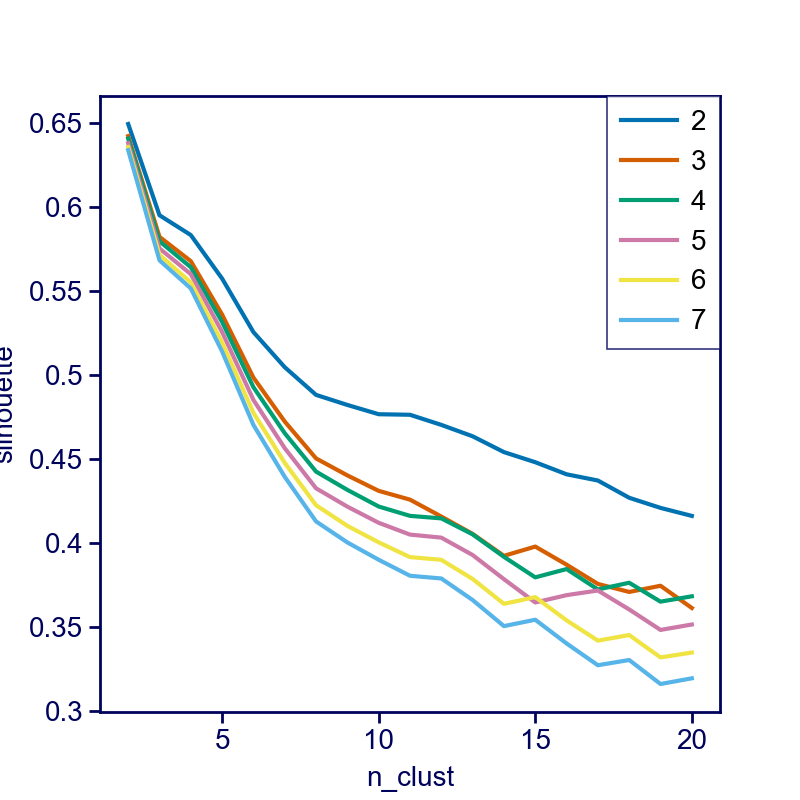

In [35]:
for n_comp in np.arange(2, 8, 1):
    df_toplot = df_stats.query(f'n_comp=={n_comp}')
    sns.lineplot(data=df_toplot, y='silhouette', x='n_clust', label=n_comp)

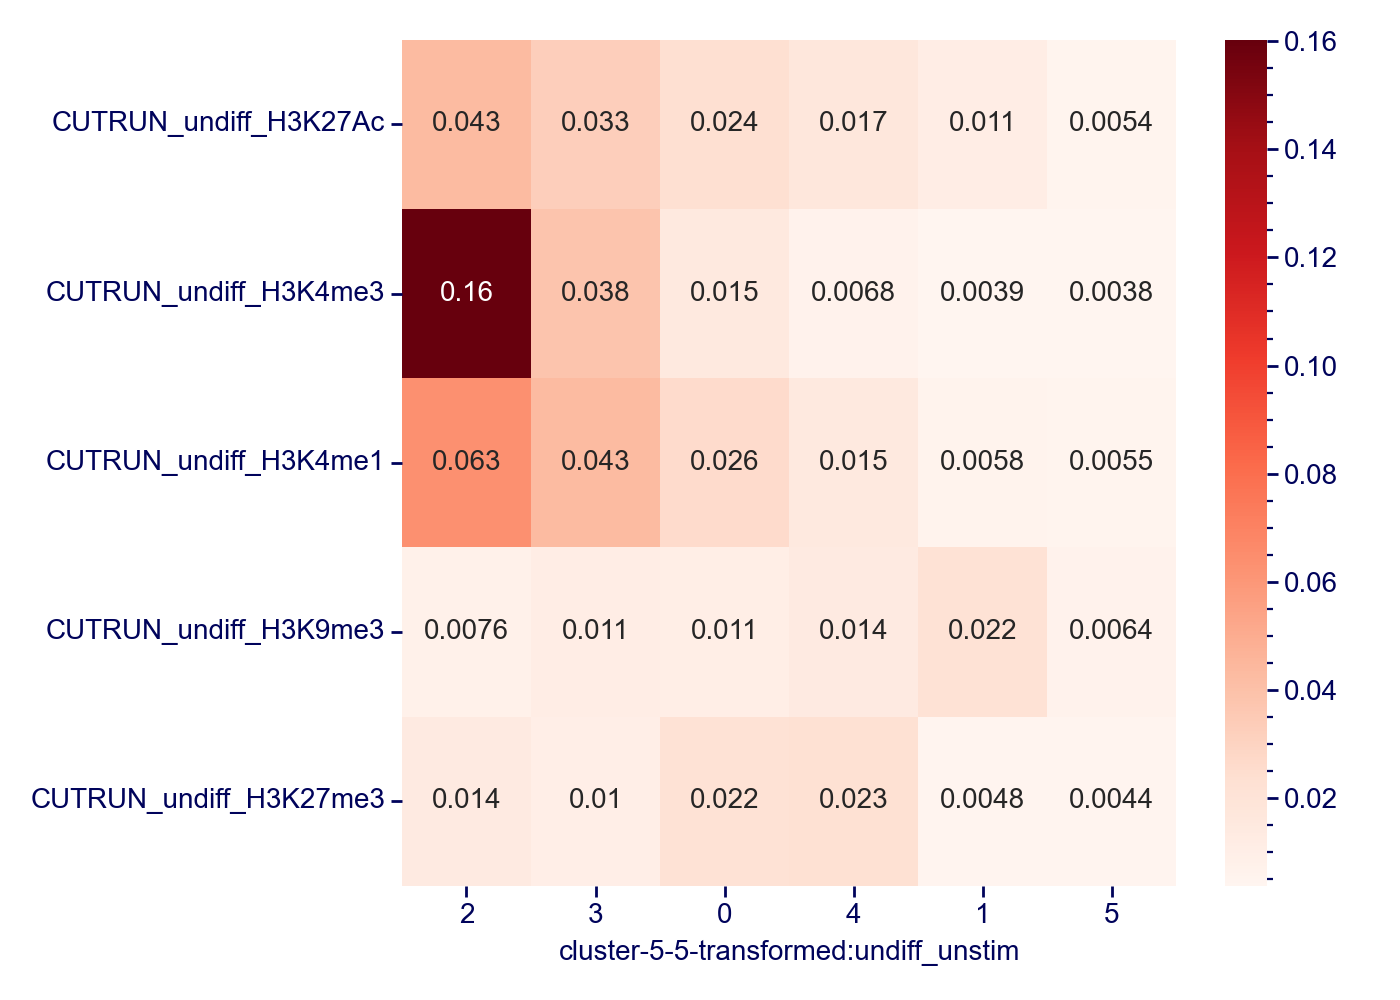

In [36]:
# Visually assess reordering:
n_comp = 5
n_clusters = 5
output_name = f"cluster-{n_comp}-{n_clusters}-{mode}"
cond = 'undiff_unstim'
col = f'{output_name}:{cond}'
col_toplot = [
    'CUTRUN_undiff_H3K27Ac',
    'CUTRUN_undiff_H3K4me3',
    'CUTRUN_undiff_H3K4me1',
    'CUTRUN_undiff_H3K9me3',
    'CUTRUN_undiff_H3K27me3',
]

df_toplot = bins_region.groupby(col).mean()[col_toplot]
plt.figure(figsize=[7, 5])
sns.heatmap(df_toplot.sort_values(['CUTRUN_undiff_H3K27Ac', 'CUTRUN_undiff_H3K4me3'], ascending=False).T, cmap='Reds', annot=True)
plt.tight_layout()

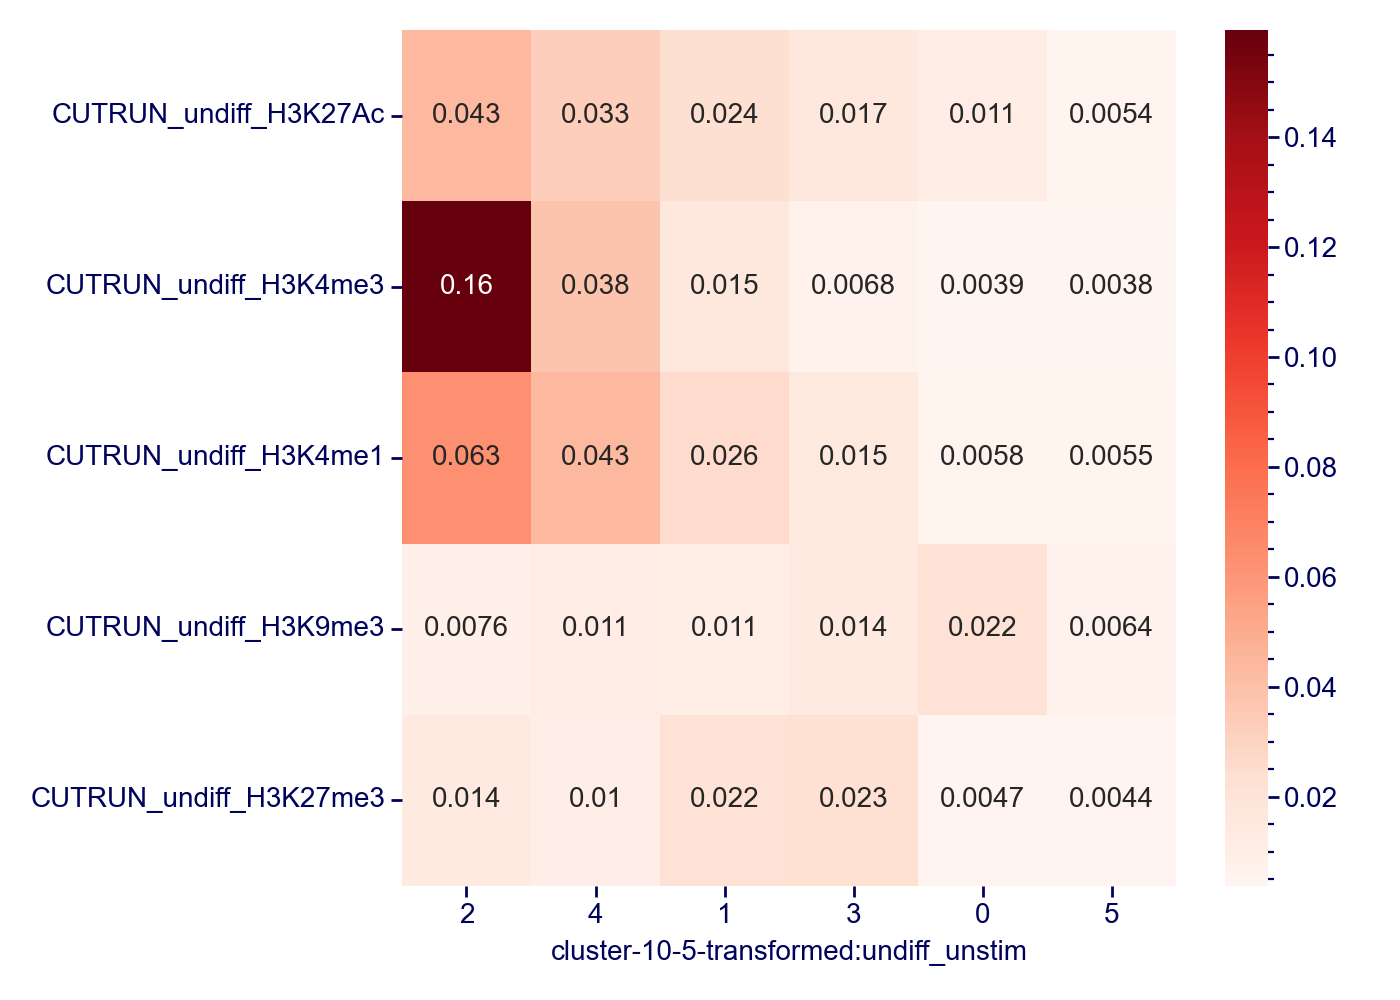

In [37]:
# Visually assess reordering:
n_comp = 10
n_clusters = 5
output_name = f"cluster-{n_comp}-{n_clusters}-{mode}"
cond = 'undiff_unstim'
col = f'{output_name}:{cond}'
col_toplot = [
    'CUTRUN_undiff_H3K27Ac',
    'CUTRUN_undiff_H3K4me3',
    'CUTRUN_undiff_H3K4me1',
    'CUTRUN_undiff_H3K9me3',
    'CUTRUN_undiff_H3K27me3',
]

df_toplot = bins_region.groupby(col).mean()[col_toplot]
plt.figure(figsize=[7, 5])
sns.heatmap(df_toplot.sort_values(['CUTRUN_undiff_H3K27Ac', 'CUTRUN_undiff_H3K4me3'], ascending=False).T, cmap='Reds', annot=True)
plt.tight_layout()

In [38]:
list_cluster_reorder = list( df_toplot.sort_values(['CUTRUN_undiff_H3K27Ac', 'CUTRUN_undiff_H3K4me3'], ascending=False).T.columns.values )
# dict_cluster_names = dict(enumerate(['A1', 'A2', 'Bi', 'Polycomb', 'B1', 'B2', 'Quies']))

In [39]:
# Re-order the clusters:
n_comp = 10
n_clusters = 5
output_name = f"cluster-{n_comp}-{n_clusters}-{mode}"
output_cols = [f"{output_name}:{cond}" for cond in conditions]
bins_region.loc[:, output_cols] = (bins_region.loc[:, output_cols].replace( list_cluster_reorder, 2*n_clusters+np.arange(n_clusters+1) ).astype(int)-2*n_clusters).astype('category')

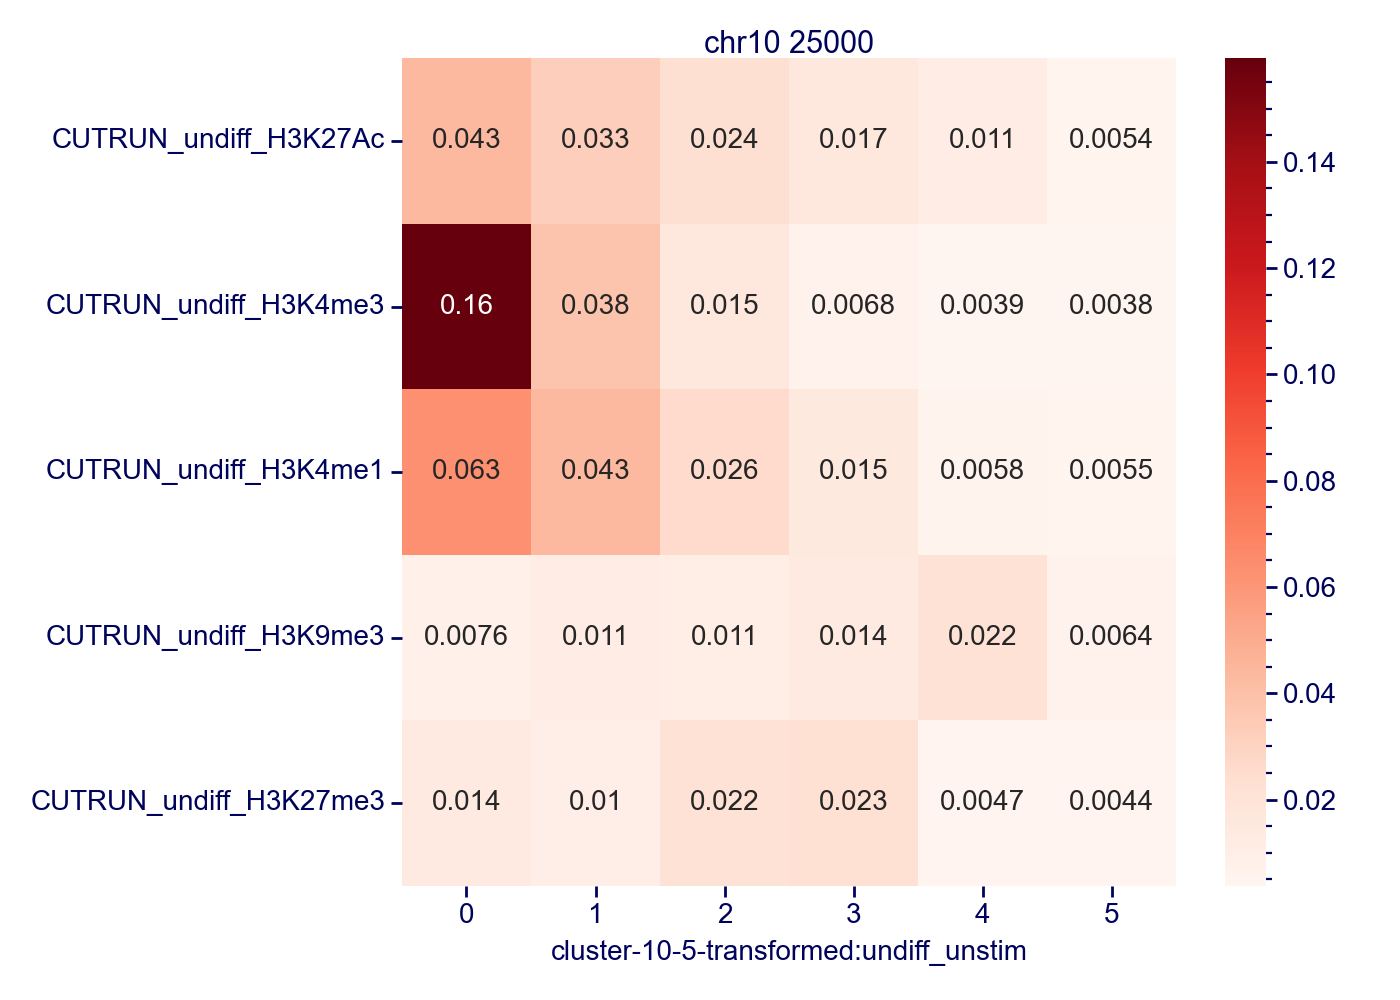

In [40]:
# Check re-ordering
cond = 'undiff_unstim'
col = f'cluster-{n_comp}-{n_clusters}-{mode}:{cond}'
col_toplot = [
    'CUTRUN_undiff_H3K27Ac',
    'CUTRUN_undiff_H3K4me3',
    'CUTRUN_undiff_H3K4me1',
    'CUTRUN_undiff_H3K9me3',
    'CUTRUN_undiff_H3K27me3',
]

df_toplot = bins_region.groupby(col).mean()[col_toplot]
plt.figure(figsize=[7, 5])
sns.heatmap(df_toplot.sort_values(['CUTRUN_undiff_H3K27Ac', 'CUTRUN_undiff_H3K4me3'], ascending=False).T, cmap='Reds', annot=True)

plt.title(f"{CHROM} {BINSIZE}", y=0.99)
plt.tight_layout()

# plt.savefig(f"{OUTPUT_FOLDER}/heatmap.clusters-annotation.{CHROM}.{BINSIZE}.png")
# plt.savefig(f"{OUTPUT_FOLDER}/heatmap.clusters-annotation.{CHROM}.{BINSIZE}.pdf")

In [41]:
### Write the output:
n_comp = 5
n_clusters = 5

n_comp_towrite = 10

output_name = f"cluster-{n_comp}-{n_clusters}-{mode}"
output_cols = [f"{output_name}:{cond}" for cond in conditions]
cols_small = ['chrom', 'start', 'end'] + ['is_bin_valid'] + output_cols
cols = [x for x in bins_region.columns if ('cluster' not in x)] + output_cols

if MODE.startswith("R"):
    pass 
elif MODE.startswith("W"):
    df_stats.to_csv(f'{OUTPUT_FOLDER}/output_clustering_stats.{CHROM}.{BINSIZE}.csv')
    bins_region.loc[:, cols].to_csv(f'{OUTPUT_FOLDER}/output_table.{CHROM}.{BINSIZE}.csv')
    bins_region.loc[:, cols_small].to_csv(f'{OUTPUT_FOLDER}/output_table_small.{CHROM}.{BINSIZE}.csv')
    bins_region.to_csv(f'{OUTPUT_FOLDER}/output_table_full.{CHROM}.{BINSIZE}.csv')
else:
    raise Exception(f"MODE {MODE} is not implemented")